# System preparation

## Import libraries

In [ ]:
#pip install scikit-plot

In [194]:
# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
# Data 
import numpy as np
import pandas as pd

#Regular expressions
import re as re

# Utilities
from time import time

#Features importance
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor

# Others
import warnings
from functools import reduce
from pathlib import Path
import os


In [2]:
# Configurations.
%matplotlib inline
sns.set_style("darkgrid")
warnings.filterwarnings("ignore")
plt.rc("font", family="serif", size=15)

# Feature engineering

The data acquisition step deals with collecting measurement data from the sensors and processing the raw signal to extract useful features that could indicate the system’s health state. This latter task is commonly known as feature engineering in data science.

### Read data 

In [3]:
# Load csv data with pandas
sensors = pd.read_csv("../data/sensors_clean.csv", error_bad_lines=False, index_col=0)
failures = pd.read_csv("../data/failures_clean.csv", error_bad_lines=False, index_col=0)

errors = pd.read_csv("../data/errors_clean.csv", error_bad_lines=False, index_col=0)
maintenance = pd.read_csv("../data/maintenance_clean.csv", error_bad_lines=False, index_col=0)
compressor_info = pd.read_csv("../data/compressor_info_clean.csv", error_bad_lines=False, index_col=0)

Convert to datetime format


In [4]:
sensors["datetime"] = pd.to_datetime(sensors["datetime"], format="%Y-%m-%d %H:%M:%S")
failures["datetime"] = pd.to_datetime(failures["datetime"], format="%Y-%m-%d %H:%M:%S")
errors["datetime"] = pd.to_datetime(errors["datetime"], format="%Y-%m-%d %H:%M:%S")
maintenance["datetime"] = pd.to_datetime(maintenance["datetime"], format="%Y-%m-%d %H:%M:%S")


### Time window

**Variable time window**

A variable time window will be created.


In [5]:
# Size of the time window
time_window_resample_hours = 3

Telemetry data usually comes with timestamps, which makes it suitable for calculating lagging features (statistics of certain values within a time window)

Once the size of the window has been chosen, we will calculate the aggregated measures (mean, standard deviation, minimum, maximum, etc.) to represent the **short-term history.**

In [6]:
# Name of the columns
temp = []
sensor_vars = ["current", "rpm", "pressure", "vibration"]

We will create a pivot table because we need the datetime as an index in order to resample and create the lagging

- Closed = 'right' => (6:00, 9:00] or 6:00 <x <= 9:00

- Closed = 'left' => [6:00, 9:00) or 6:00 <= x <9:00


We will unstack in order to return the dataframe to original format

Unstack shows a dataseries on the columns as an index and returns series (if there are several indexes they are rearranged)

Each dataframe in temp has the values of the field that corresponds to it at that moment.

In [7]:
# Temporary list containing the pivot table
temp = [
    pd.pivot_table(
        sensors,
        index="datetime",
        columns="compressorID",
        values=col).resample( str(time_window_resample_hours) + "H", closed="left", label="right").mean().unstack()
    for col in sensor_vars
]

In [8]:
# Concat the pivot table and create a dataframe
sensors_mean_tw = pd.concat(temp, axis=1) # Unify the series
sensors_mean_tw.columns = [col + "_mean_" + str(time_window_resample_hours) + "h" for col in sensor_vars] # Asign names to the columns
sensors_mean_tw.reset_index(inplace=True) 
sensors_mean_tw.head()

compressorID            datetime  current_mean_3h  rpm_mean_3h  \
0             1 2015-01-01 09:00:00       170.028993   449.533798   
1             1 2015-01-01 12:00:00       164.192565   403.949857   
2             1 2015-01-01 15:00:00       168.134445   435.781707   
3             1 2015-01-01 18:00:00       165.514453   430.472823   
4             1 2015-01-01 21:00:00       168.809347   437.111120   

   pressure_mean_3h  vibration_mean_3h  
0         94.592122          40.893502  
1        105.687417          34.255891  
2        107.793709          41.239405  
3        101.703289          40.373739  
4         90.911060          41.738542

In [9]:
# Period with sensor data
date_range = pd.date_range(sensors.datetime.min(), sensors.datetime.max(), freq='3H')

In [10]:
sensors.shape

(876100, 6)

In [11]:
sensors_mean_tw.shape

(292100, 6)

Let's plot one of the variables, for example the current, first the raw data and second after the transformation using the time window.





In [12]:
# Select the compressor
machine_ID = 1

# We establish the times corresponding to the records that will be used for ploting the data
initial_date = pd.to_datetime("2015-01-01 05:00:00")
final_date = pd.to_datetime("2015-01-15 05:00:00")

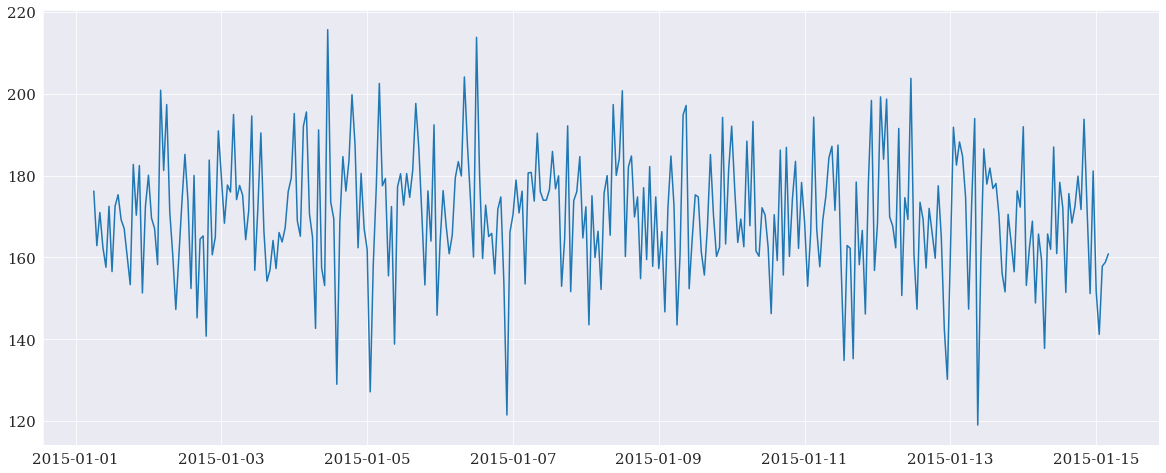

In [13]:
# Plot raw data
plt.figure(figsize=(20, 8))
sensors_filtered = sensors[(sensors['compressorID']==1) &
                           (sensors['datetime']>initial_date) &
                           (sensors['datetime']<final_date)]
plt.plot(sensors_filtered['datetime'], sensors_filtered['current'])

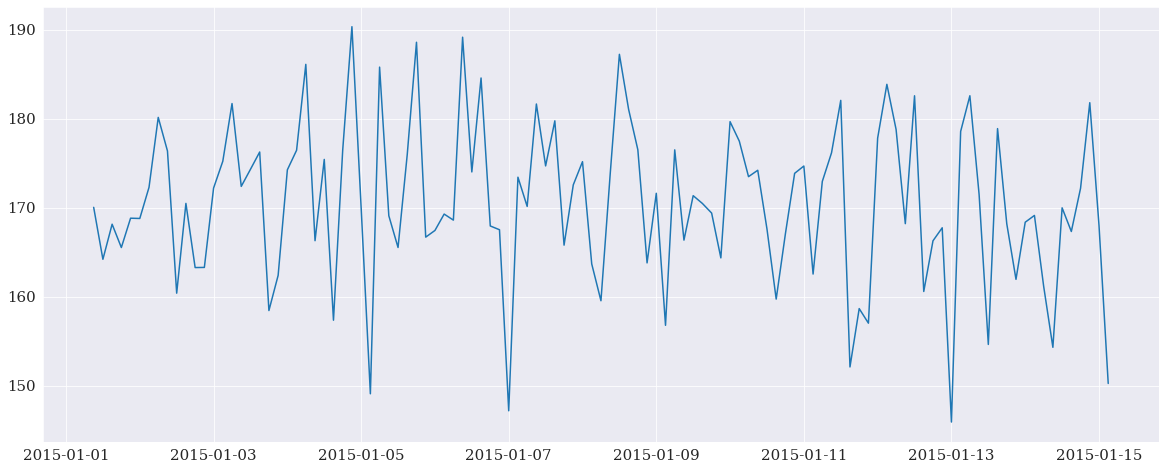

In [14]:
# Plot time window
plt.figure(figsize=(20, 8))
sensors_filtered = sensors_mean_tw[(sensors_mean_tw['compressorID']==1) &
                           (sensors_mean_tw['datetime']>initial_date) &
                           (sensors_mean_tw['datetime']<final_date)]
plt.plot(sensors_filtered['datetime'], sensors_filtered['current'+ "_mean_" + str(time_window_resample_hours) + "h"])

For standard deviation

In [15]:
# Temporary list
temp = [
    pd.pivot_table(
        sensors,
        index="datetime",
        columns="compressorID",
        values=col).resample( str(time_window_resample_hours) + "H", closed="left", label="right").std().unstack()
    for col in sensor_vars
]

In [16]:
# Concat the temporary lists
sensors_std_tw = pd.concat(temp, axis=1) # Unify the series
sensors_std_tw.columns = [col + "_std_" + str(time_window_resample_hours) + "h" for col in sensor_vars] # Asign names to the columns
sensors_std_tw.reset_index(inplace=True) 
sensors_std_tw.head()

compressorID            datetime  current_std_3h  rpm_std_3h  \
0             1 2015-01-01 09:00:00        6.721032   67.849599   
1             1 2015-01-01 12:00:00        7.596570   50.120452   
2             1 2015-01-01 15:00:00       10.124584   55.084734   
3             1 2015-01-01 18:00:00        4.673269   42.047278   
4             1 2015-01-01 21:00:00       14.752132   47.048609   

   pressure_std_3h  vibration_std_3h  
0        18.934956          5.874970  
1         8.555032          7.662229  
2         5.909721          5.169304  
3         4.554047          2.106108  
4         4.244158          2.207884

For max and min

In [17]:
# Temporary list max
temp = [
    pd.pivot_table(
        sensors,
        index="datetime",
        columns="compressorID",
        values=col).resample( str(time_window_resample_hours) + "H", closed="left", label="right").max().unstack()
    for col in sensor_vars
]
sensors_max_tw = pd.concat(temp, axis=1) # Unify the series
sensors_max_tw.columns = [col + "_max_" + str(time_window_resample_hours) + "h" for col in sensor_vars] # Asign names to the columns
sensors_max_tw.reset_index(inplace=True) 
sensors_max_tw.head()

compressorID            datetime  current_max_3h  rpm_max_3h  \
0             1 2015-01-01 09:00:00      176.217853  527.349825   
1             1 2015-01-01 12:00:00      172.504839  435.376873   
2             1 2015-01-01 15:00:00      175.324524  499.071623   
3             1 2015-01-01 18:00:00      169.218423  460.850670   
4             1 2015-01-01 21:00:00      182.739113  490.672921   

   pressure_max_3h  vibration_max_3h  
0       113.077935         45.087686  
1       111.886648         41.122144  
2       111.755684         45.482287  
3       104.848230         42.675800  
4        93.484954         44.108554

In [18]:
# Temporary list min
temp = [
    pd.pivot_table(
        sensors,
        index="datetime",
        columns="compressorID",
        values=col).resample( str(time_window_resample_hours) + "H", closed="left", label="right").min().unstack()
    for col in sensor_vars
]
sensors_min_tw = pd.concat(temp, axis=1) # Unify the series
sensors_min_tw.columns = [col + "_min_" + str(time_window_resample_hours) + "h" for col in sensor_vars] # Asign names to the columns
sensors_min_tw.reset_index(inplace=True) 
sensors_min_tw.head()

compressorID            datetime  current_min_3h  rpm_min_3h  \
0             1 2015-01-01 09:00:00      162.879223  402.747490   
1             1 2015-01-01 12:00:00      157.610021  346.149335   
2             1 2015-01-01 15:00:00      156.556031  398.648781   
3             1 2015-01-01 18:00:00      160.263954  382.483543   
4             1 2015-01-01 21:00:00      153.353492  402.461187   

   pressure_min_3h  vibration_min_3h  
0        75.237905         34.178847  
1        95.927042         25.990511  
2       101.001083         35.482009  
3        96.480976         38.543681  
4        86.012440         39.739883

### Lagging functions

In [19]:
# Define a lagging time period
time_lagged_sensors = 24

To capture a longer-term effect, we will create lagging functions and then select first value from the time window.


In [20]:
# Create temporary list
temp = []
temp = [
    pd.pivot_table(
        sensors,
        index="datetime",
        columns="compressorID",
        values=col).rolling(window=time_lagged_sensors).mean().
        resample(str(time_window_resample_hours) + "H", closed="left", label="right").first().unstack()
    for col in sensor_vars
]

In [21]:
# Concat all temporary lists
sensors_mean_lagging = pd.concat(temp, axis=1) # Unify the series
sensors_mean_lagging.columns = [col + "_mean_lag_" + str(time_lagged_sensors) + "h" for col in sensor_vars] # Asign names to the columns
sensors_mean_lagging.reset_index(inplace=True) 
sensors_mean_lagging.head(10)

compressorID            datetime  current_mean_lag_24h  rpm_mean_lag_24h  \
0             1 2015-01-01 09:00:00                   NaN               NaN   
1             1 2015-01-01 12:00:00                   NaN               NaN   
2             1 2015-01-01 15:00:00                   NaN               NaN   
3             1 2015-01-01 18:00:00                   NaN               NaN   
4             1 2015-01-01 21:00:00                   NaN               NaN   
5             1 2015-01-02 00:00:00                   NaN               NaN   
6             1 2015-01-02 03:00:00                   NaN               NaN   
7             1 2015-01-02 06:00:00            169.733809        445.179865   
8             1 2015-01-02 09:00:00            170.614862        446.364859   
9             1 2015-01-02 12:00:00            169.893965        447.009407   

   pressure_mean_lag_24h  vibration_mean_lag_24h  
0                    NaN                     NaN  
1                    NaN                     NaN  
2                    NaN                     NaN  
3                    NaN                     NaN  
4                    NaN                     NaN  
5                    NaN                     NaN  
6                    NaN                     NaN  
7              96.797113               40.385160  
8              96.849785               39.736826  
9              97.715600               39.498374

Let's plot one of the variables, for example the current, first the raw data, second after the transformation using the time window and third after the lagging period



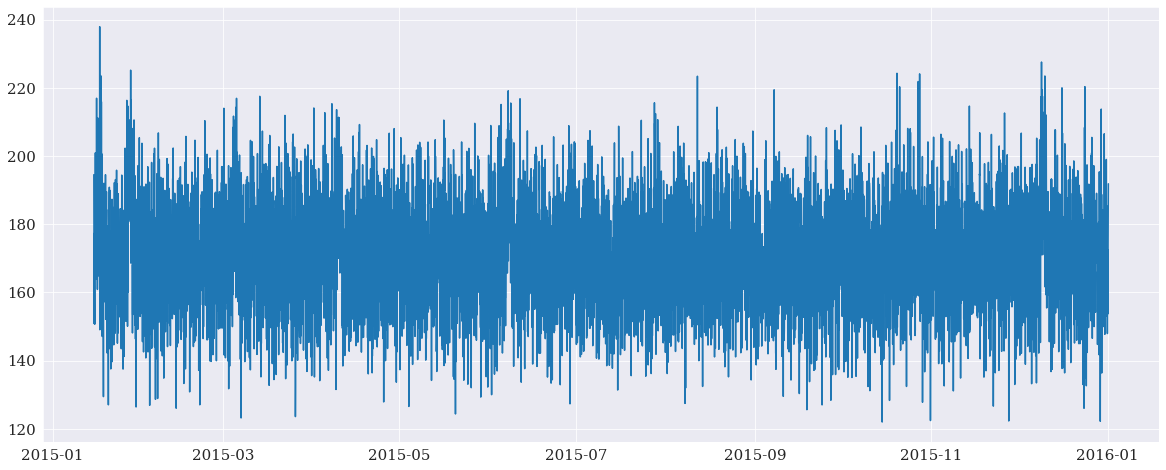

In [22]:
# Plot Raw Data
plt.figure(figsize=(20, 8))
sensors_filtered = sensors[(sensors['compressorID']==1) &
                           (sensors['datetime']>initial_date) &
                           (sensors['datetime']>final_date)]
plt.plot(sensors_filtered['datetime'], sensors_filtered['current'])

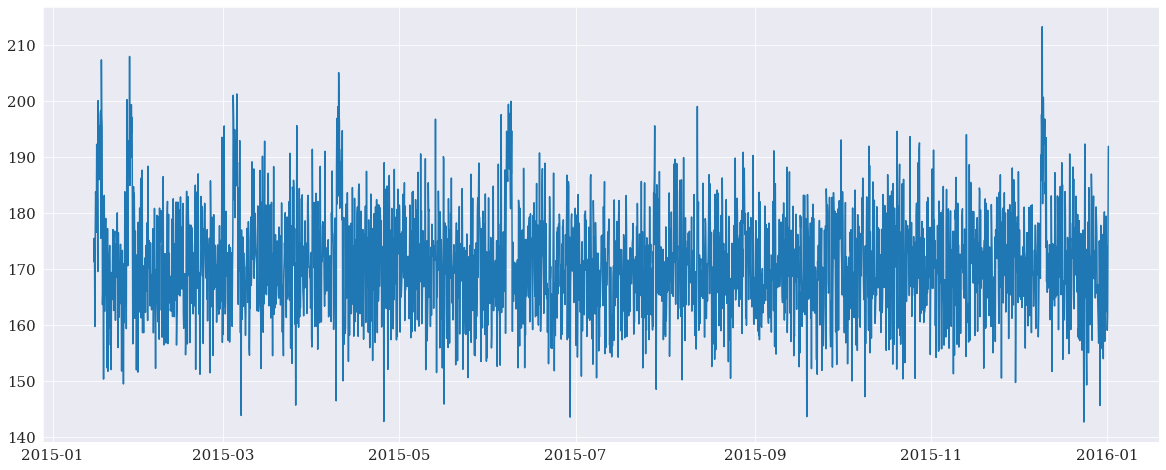

In [23]:
# Plot time window
plt.figure(figsize=(20, 8))
sensors_filtered = sensors_mean_tw[(sensors_mean_tw['compressorID']==1) &
                           (sensors_mean_tw['datetime']>initial_date) &
                           (sensors_mean_tw['datetime']>final_date)]
plt.plot(sensors_filtered['datetime'], sensors_filtered['current'+ "_mean_" + str(time_window_resample_hours) + "h"])

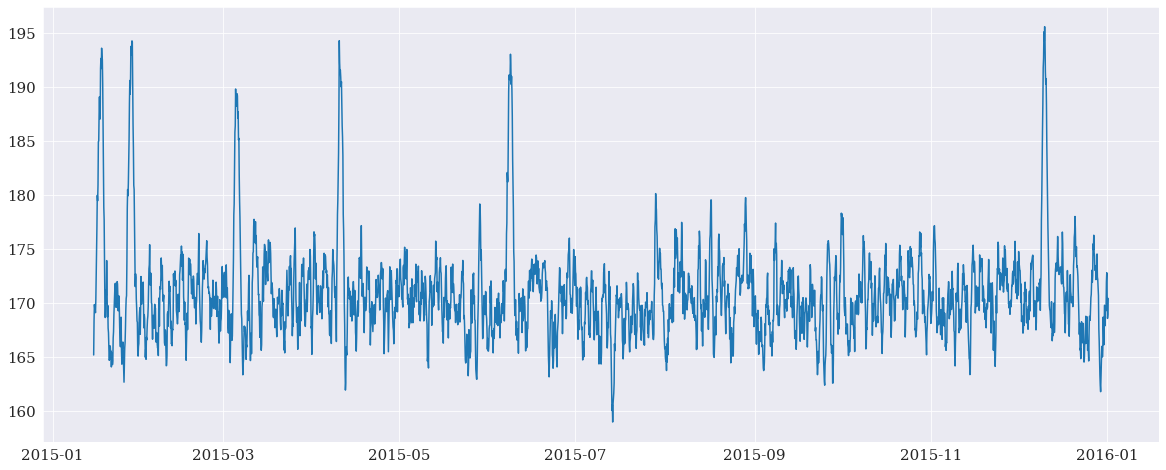

In [24]:
# Plot lagging
plt.figure(figsize=(20, 8))
sensors_filtered = sensors_mean_lagging[(sensors_mean_lagging['compressorID']==1) &
                                        (sensors_mean_lagging['datetime']>initial_date) &
                                        (sensors_mean_lagging['datetime']>final_date)]
plt.plot(sensors_filtered['datetime'], sensors_filtered['current'+ "_mean_lag_" + str(time_lagged_sensors) + "h"])

For standard deviation

In [25]:
# Temporary list
temp = []
temp = [
    pd.pivot_table(
        sensors,
        index="datetime",
        columns="compressorID",
        values=col).rolling(window=time_lagged_sensors).std().
        resample(str(time_window_resample_hours) + "H", closed="left", label="right").first().unstack()
    for col in sensor_vars
]

In [26]:
# Concat temporary lists
sensors_std_lagging = pd.concat(temp, axis=1) # Unify the series
sensors_std_lagging.columns = [col + "_std_lag_" + str(time_lagged_sensors) + "h" for col in sensor_vars] # Asign names to the columns
sensors_std_lagging.reset_index(inplace=True) 
sensors_std_lagging.head(10)

compressorID            datetime  current_std_lag_24h  rpm_std_lag_24h  \
0             1 2015-01-01 09:00:00                  NaN              NaN   
1             1 2015-01-01 12:00:00                  NaN              NaN   
2             1 2015-01-01 15:00:00                  NaN              NaN   
3             1 2015-01-01 18:00:00                  NaN              NaN   
4             1 2015-01-01 21:00:00                  NaN              NaN   
5             1 2015-01-02 00:00:00                  NaN              NaN   
6             1 2015-01-02 03:00:00                  NaN              NaN   
7             1 2015-01-02 06:00:00            11.233120        48.717395   
8             1 2015-01-02 09:00:00            12.519402        48.385076   
9             1 2015-01-02 12:00:00            13.370357        42.432317   

   pressure_std_lag_24h  vibration_std_lag_24h  
0                   NaN                    NaN  
1                   NaN                    NaN  
2                   NaN                    NaN  
3                   NaN                    NaN  
4                   NaN                    NaN  
5                   NaN                    NaN  
6                   NaN                    NaN  
7             10.079880               5.853209  
8             10.171540               6.163231  
9              9.471669               6.195076

For max and min

In [27]:
# Temp list
temp = []
temp = [
    pd.pivot_table(
        sensors,
        index="datetime",
        columns="compressorID",
        values=col).rolling(window=time_lagged_sensors).max().
        resample(str(time_window_resample_hours) + "H", closed="left", label="right").first().unstack()
    for col in sensor_vars
]
sensors_max_lagging = pd.concat(temp, axis=1) # Unify the series
sensors_max_lagging.columns = [col + "_max_lag_" + str(time_lagged_sensors) + "h" for col in sensor_vars] # Asign names to the columns
sensors_max_lagging.reset_index(inplace=True) 
sensors_max_lagging.head(10)

compressorID            datetime  current_max_lag_24h  rpm_max_lag_24h  \
0             1 2015-01-01 09:00:00                  NaN              NaN   
1             1 2015-01-01 12:00:00                  NaN              NaN   
2             1 2015-01-01 15:00:00                  NaN              NaN   
3             1 2015-01-01 18:00:00                  NaN              NaN   
4             1 2015-01-01 21:00:00                  NaN              NaN   
5             1 2015-01-02 00:00:00                  NaN              NaN   
6             1 2015-01-02 03:00:00                  NaN              NaN   
7             1 2015-01-02 06:00:00            200.87243       527.349825   
8             1 2015-01-02 09:00:00            200.87243       527.349825   
9             1 2015-01-02 12:00:00            200.87243       519.452812   

   pressure_max_lag_24h  vibration_max_lag_24h  
0                   NaN                    NaN  
1                   NaN                    NaN  
2                   NaN                    NaN  
3                   NaN                    NaN  
4                   NaN                    NaN  
5                   NaN                    NaN  
6                   NaN                    NaN  
7            113.077935              52.355876  
8            114.342061              52.355876  
9            114.342061              52.355876

In [28]:
#Temp list
temp = []
temp = [
    pd.pivot_table(
        sensors,
        index="datetime",
        columns="compressorID",
        values=col).rolling(window=time_lagged_sensors).min().
        resample(str(time_window_resample_hours) + "H", closed="left", label="right").first().unstack()
    for col in sensor_vars
]
sensors_min_lagging = pd.concat(temp, axis=1) # Unify the series
sensors_min_lagging.columns = [col + "_min_lag_" + str(time_lagged_sensors) + "h" for col in sensor_vars] # Asign names to the columns
sensors_min_lagging.reset_index(inplace=True) 
sensors_min_lagging.head(10)

compressorID            datetime  current_min_lag_24h  rpm_min_lag_24h  \
0             1 2015-01-01 09:00:00                  NaN              NaN   
1             1 2015-01-01 12:00:00                  NaN              NaN   
2             1 2015-01-01 15:00:00                  NaN              NaN   
3             1 2015-01-01 18:00:00                  NaN              NaN   
4             1 2015-01-01 21:00:00                  NaN              NaN   
5             1 2015-01-02 00:00:00                  NaN              NaN   
6             1 2015-01-02 03:00:00                  NaN              NaN   
7             1 2015-01-02 06:00:00           151.335682       346.149335   
8             1 2015-01-02 09:00:00           151.335682       346.149335   
9             1 2015-01-02 12:00:00           147.300678       382.483543   

   pressure_min_lag_24h  vibration_min_lag_24h  
0                   NaN                    NaN  
1                   NaN                    NaN  
2                   NaN                    NaN  
3                   NaN                    NaN  
4                   NaN                    NaN  
5                   NaN                    NaN  
6                   NaN                    NaN  
7             75.237905              25.990511  
8             75.237905              25.990511  
9             78.880780              25.990511

### Combine time window and lagging



We combine the features created so far. We take the values 2: 6 to avoid duplicate IDs and dates. 

axis = 0 we move in the direction of the rows, axis = 1, we move in the direction of the columns.

In [29]:
# Concat all the sensor data columns
sensors_feat = pd.concat([
    sensors_mean_tw,
    sensors_std_tw.iloc[:, 2:6],
    sensors_max_tw.iloc[:, 2:6],
    sensors_min_tw.iloc[:, 2:6],
    sensors_mean_lagging.iloc[:, 2:6],
    sensors_std_lagging.iloc[:, 2:6],
    sensors_max_lagging.iloc[:,2:6],
    sensors_min_lagging.iloc[:,2:6]], axis=1)
sensors_feat.head()

compressorID            datetime  current_mean_3h  rpm_mean_3h  \
0             1 2015-01-01 09:00:00       170.028993   449.533798   
1             1 2015-01-01 12:00:00       164.192565   403.949857   
2             1 2015-01-01 15:00:00       168.134445   435.781707   
3             1 2015-01-01 18:00:00       165.514453   430.472823   
4             1 2015-01-01 21:00:00       168.809347   437.111120   

   pressure_mean_3h  vibration_mean_3h  current_std_3h  rpm_std_3h  \
0         94.592122          40.893502        6.721032   67.849599   
1        105.687417          34.255891        7.596570   50.120452   
2        107.793709          41.239405       10.124584   55.084734   
3        101.703289          40.373739        4.673269   42.047278   
4         90.911060          41.738542       14.752132   47.048609   

   pressure_std_3h  vibration_std_3h  ...  pressure_std_lag_24h  \
0        18.934956          5.874970  ...                   NaN   
1         8.555032          7.662229  ...                   NaN   
2         5.909721          5.169304  ...                   NaN   
3         4.554047          2.106108  ...                   NaN   
4         4.244158          2.207884  ...                   NaN   

   vibration_std_lag_24h  current_max_lag_24h  rpm_max_lag_24h  \
0                    NaN                  NaN              NaN   
1                    NaN                  NaN              NaN   
2                    NaN                  NaN              NaN   
3                    NaN                  NaN              NaN   
4                    NaN                  NaN              NaN   

   pressure_max_lag_24h  vibration_max_lag_24h  current_min_lag_24h  \
0                   NaN                    NaN                  NaN   
1                   NaN                    NaN                  NaN   
2                   NaN                    NaN                  NaN   
3                   NaN                    NaN                  NaN   
4                   NaN                    NaN                  NaN   

   rpm_min_lag_24h  pressure_min_lag_24h  vibration_min_lag_24h  
0              NaN                   NaN                    NaN  
1              NaN                   NaN                    NaN  
2              NaN                   NaN                    NaN  
3              NaN                   NaN                    NaN  
4              NaN                   NaN                    NaN  

[5 rows x 34 columns]

### Errors

Telemetry data, similarly to errors, also come with timestamps. We will include in the model raw error data and the count of the errors in a lagged period. 


1. Errors produced in a specific moment of time.
2. Lagged errors. The intention is to see if errors in previous periods of time could affect the failure to happen

In [30]:
# Filter by dates
errors = errors.loc[(errors['datetime']>sensors_feat['datetime'].min()) &
                    (errors['datetime']<sensors_feat['datetime'].max())]

In [31]:
errors['errorID'].value_counts()

error1    1010
error2     987
error3     834
error4     726
error5     356
Name: errorID, dtype: int64

We start by formatting the error data to have one entry per compressor per time when at least one error occurred. We create a column for each type of error.

In [32]:
errors.head()

datetime  compressorID errorID
0    2015-01-04 07:00:00             1  error1
1    2015-01-04 20:00:00             1  error3
2    2015-01-05 06:00:00             1  error5
3    2015-01-11 15:00:00             1  error4
4    2015-01-23 10:00:00             1  error4
...                  ...           ...     ...
3914 2015-11-22 08:00:00           100  error2
3915 2015-12-05 02:00:00           100  error1
3916 2015-12-09 06:00:00           100  error2
3917 2015-12-09 06:00:00           100  error3
3918 2015-12-23 03:00:00           100  error3

[3913 rows x 3 columns]

In [33]:
errors_dum = pd.get_dummies(errors) # We put a 1 if the error appears for that machine, 0 otherwise.
errors_dum.columns = ["datetime", "compressorID", "error1", "error2", "error3", "error4", "error5"]

The dates in the dataframe are repeated, so we group by date. We combine errors for a given machine at a specific time. We do sum in case there are multiple errors of the same type at the same time, but not expected.

In [34]:
errors_dum = errors_dum.groupby(["compressorID", "datetime"]).sum().reset_index()


Since errors datetimes are not following same window format, we will merge it with the previous row in the error counts dataset. 

For that we wil use merge_asof and use as a tolerance a slightly small number of hours than from the time_window used for the rows

In [35]:
# Create aux dataFrame
merged_df = pd.DataFrame()
#Tolerance, slightly smaller number than the time_window
tolerance_hours= pd.Timedelta(str(time_window_resample_hours-0.001)+ "h")

#We will go compressor by compressor
for num_comp in errors_dum.compressorID.unique():

  #Selecting only one compressor by compressor ID
  sensors_feat_ind = sensors_feat[sensors_feat['compressorID']== num_comp]
  errors_ind = errors_dum[errors_dum['compressorID']==num_comp]

  #Order compressor values by datetime
  sensors_feat_ind.sort_values('datetime' , inplace= True)
  errors_ind.sort_values('datetime' , inplace= True)

  #Drop compressorID since it's already in one dataset
  sensors_feat_ind.drop('compressorID',axis=1, inplace=True)

  newdf=pd.merge_asof( sensors_feat_ind, errors_ind,  on="datetime",tolerance=tolerance_hours , allow_exact_matches=True, direction='backward')

  #Append for each different compressorID
  merged_df = merged_df.append(newdf)

errors_merged= merged_df.copy()

#Remove sensor data

errors_merged = errors_merged[list(errors_dum.columns)]
errors_merged.dropna(axis=0,inplace=True)

errors_merged.sort_values(['compressorID','datetime'], inplace=True)
errors_merged.reset_index(drop=True, inplace=True)

In [36]:
errors_merged.head()

compressorID            datetime  error1  error2  error3  error4  error5
0              1.0 2015-01-04 09:00:00     1.0     0.0     0.0     0.0     0.0
1              1.0 2015-01-04 21:00:00     0.0     0.0     1.0     0.0     0.0
2              1.0 2015-01-05 06:00:00     0.0     0.0     0.0     0.0     1.0
3              1.0 2015-01-11 15:00:00     0.0     0.0     0.0     1.0     0.0
4              1.0 2015-01-23 12:00:00     0.0     0.0     0.0     1.0     0.0
...            ...                 ...     ...     ...     ...     ...     ...
3593         100.0 2015-11-13 03:00:00     1.0     0.0     0.0     0.0     0.0
3594         100.0 2015-11-22 09:00:00     0.0     1.0     0.0     0.0     0.0
3595         100.0 2015-12-05 03:00:00     1.0     0.0     0.0     0.0     0.0
3596         100.0 2015-12-09 06:00:00     0.0     1.0     1.0     0.0     0.0
3597         100.0 2015-12-23 03:00:00     0.0     0.0     1.0     0.0     0.0

[3598 rows x 7 columns]

In [37]:
errors_merged['error1'].value_counts()

0.0    2589
1.0    1009
Name: error1, dtype: int64

Create merge to use for the counts

In [38]:
# In order to use for count
error_count_filtered = sensors[["datetime", "compressorID"]].merge(
    errors_merged,
    on=["datetime", "compressorID"],
    how="left"
).fillna(0.0)

error_count_filtered.head()

datetime  compressorID  error1  error2  error3  error4  error5
0 2015-01-01 06:00:00             1     0.0     0.0     0.0     0.0     0.0
1 2015-01-01 07:00:00             1     0.0     0.0     0.0     0.0     0.0
2 2015-01-01 08:00:00             1     0.0     0.0     0.0     0.0     0.0
3 2015-01-01 09:00:00             1     0.0     0.0     0.0     0.0     0.0
4 2015-01-01 10:00:00             1     0.0     0.0     0.0     0.0     0.0

Create merge for the normal errors

In [39]:
# We update with datetime and compressorID from the senors_feat
errors_merged = sensors_feat[["datetime", "compressorID"]].merge(
    errors_merged,
    on=["datetime", "compressorID"],
    how="outer").fillna(0).sort_values(by=["compressorID", "datetime"]
)
errors_merged.head(10)

datetime  compressorID  error1  error2  error3  error4  error5
0 2015-01-01 09:00:00             1     0.0     0.0     0.0     0.0     0.0
1 2015-01-01 12:00:00             1     0.0     0.0     0.0     0.0     0.0
2 2015-01-01 15:00:00             1     0.0     0.0     0.0     0.0     0.0
3 2015-01-01 18:00:00             1     0.0     0.0     0.0     0.0     0.0
4 2015-01-01 21:00:00             1     0.0     0.0     0.0     0.0     0.0
5 2015-01-02 00:00:00             1     0.0     0.0     0.0     0.0     0.0
6 2015-01-02 03:00:00             1     0.0     0.0     0.0     0.0     0.0
7 2015-01-02 06:00:00             1     0.0     0.0     0.0     0.0     0.0
8 2015-01-02 09:00:00             1     0.0     0.0     0.0     0.0     0.0
9 2015-01-02 12:00:00             1     0.0     0.0     0.0     0.0     0.0

In [40]:
# Check differences
set(errors_merged['datetime']).difference(set(sensors_feat['datetime']))

set()

In [41]:
len(errors_merged)

292100

In [42]:
errors['errorID'].value_counts()

error1    1010
error2     987
error3     834
error4     726
error5     356
Name: errorID, dtype: int64

In [43]:
errors_merged['error1'].value_counts()

0.0    291091
1.0      1009
Name: error1, dtype: int64

In [44]:
errors_merged['error2'].value_counts()

0.0    291116
1.0       984
Name: error2, dtype: int64

In [45]:
errors_merged['error3'].value_counts()

0.0    291269
1.0       831
Name: error3, dtype: int64

In [46]:
errors_merged['error4'].value_counts()

0.0    291378
1.0       722
Name: error4, dtype: int64

In [47]:
errors_merged['error5'].value_counts()

0.0    291745
1.0       355
Name: error5, dtype: int64

**We count the number of errors of each type in a delayed window**

We calculate the total number of errors for each type of error during the lagging window.

In [48]:
time_errors_count = 48

In [49]:
temp = []
fields = [
    "error%d" % i
    for i in range(1,6)
]

temp = [
    pd.pivot_table(
        error_count_filtered,
        index="datetime",
        columns="compressorID",
        values=col).rolling(window=time_errors_count).sum().
        resample(str(time_window_resample_hours) + "H", closed="left", label="right").first().unstack()
    for col in fields
]
temp[0].head(10)

compressorID  datetime           
1             2015-01-01 09:00:00   NaN
              2015-01-01 12:00:00   NaN
              2015-01-01 15:00:00   NaN
              2015-01-01 18:00:00   NaN
              2015-01-01 21:00:00   NaN
              2015-01-02 00:00:00   NaN
              2015-01-02 03:00:00   NaN
              2015-01-02 06:00:00   NaN
              2015-01-02 09:00:00   NaN
              2015-01-02 12:00:00   NaN
dtype: float64

In [50]:
error_count_total = pd.concat(temp, axis=1)
error_count_total.columns = [i + "count" for i in fields]
error_count_total.reset_index(inplace=True)
error_count_total = error_count_total.dropna()
error_count_total.head()

compressorID            datetime  error1count  error2count  error3count  \
15             1 2015-01-03 06:00:00          0.0          0.0          0.0   
16             1 2015-01-03 09:00:00          0.0          0.0          0.0   
17             1 2015-01-03 12:00:00          0.0          0.0          0.0   
18             1 2015-01-03 15:00:00          0.0          0.0          0.0   
19             1 2015-01-03 18:00:00          0.0          0.0          0.0   

    error4count  error5count  
15          0.0          0.0  
16          0.0          0.0  
17          0.0          0.0  
18          0.0          0.0  
19          0.0          0.0

In [51]:
error_count_total.describe()

compressorID    error1count    error2count    error3count  \
count  290600.00000  290600.000000  290600.000000  290600.000000   
mean       50.50000       0.055344       0.054092       0.045657   
std        28.86612       0.235238       0.232145       0.213388   
min         1.00000       0.000000       0.000000       0.000000   
25%        25.75000       0.000000       0.000000       0.000000   
50%        50.50000       0.000000       0.000000       0.000000   
75%        75.25000       0.000000       0.000000       0.000000   
max       100.00000       3.000000       3.000000       3.000000   

         error4count    error5count  
count  290600.000000  290600.000000  
mean        0.039608       0.019501  
std         0.199087       0.139886  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         3.000000       2.000000

We merge the two error compositions that we saw before to create only a dataframe with error features


In [52]:
errors_feat = errors_merged.merge(error_count_total, on=["datetime", "compressorID"], how="left")
errors_feat.fillna(0.0,inplace = True)
errors_feat.head()

datetime  compressorID  error1  error2  error3  error4  error5  \
0 2015-01-01 09:00:00             1     0.0     0.0     0.0     0.0     0.0   
1 2015-01-01 12:00:00             1     0.0     0.0     0.0     0.0     0.0   
2 2015-01-01 15:00:00             1     0.0     0.0     0.0     0.0     0.0   
3 2015-01-01 18:00:00             1     0.0     0.0     0.0     0.0     0.0   
4 2015-01-01 21:00:00             1     0.0     0.0     0.0     0.0     0.0   

   error1count  error2count  error3count  error4count  error5count  
0          0.0          0.0          0.0          0.0          0.0  
1          0.0          0.0          0.0          0.0          0.0  
2          0.0          0.0          0.0          0.0          0.0  
3          0.0          0.0          0.0          0.0          0.0  
4          0.0          0.0          0.0          0.0          0.0

In [53]:
initial_date = pd.to_datetime("2015-04-18 05:00:00")
final_date = pd.to_datetime("2015-04-20 05:00:00")

In [54]:
errors_feat.loc[(errors_feat['compressorID']==2)&
                         (errors_feat['datetime']>initial_date)&
                         (errors_feat['datetime']<final_date)]

datetime  compressorID  error1  error2  error3  error4  \
3776 2015-04-18 06:00:00             2     0.0     1.0     1.0     0.0   
3777 2015-04-18 09:00:00             2     0.0     0.0     0.0     0.0   
3778 2015-04-18 12:00:00             2     0.0     0.0     0.0     0.0   
3779 2015-04-18 15:00:00             2     0.0     0.0     0.0     0.0   
3780 2015-04-18 18:00:00             2     0.0     0.0     0.0     0.0   
3781 2015-04-18 21:00:00             2     0.0     0.0     0.0     0.0   
3782 2015-04-19 00:00:00             2     0.0     0.0     0.0     0.0   
3783 2015-04-19 03:00:00             2     0.0     0.0     0.0     0.0   
3784 2015-04-19 06:00:00             2     0.0     0.0     0.0     0.0   
3785 2015-04-19 09:00:00             2     0.0     0.0     0.0     0.0   
3786 2015-04-19 12:00:00             2     0.0     0.0     0.0     0.0   
3787 2015-04-19 15:00:00             2     0.0     0.0     0.0     0.0   
3788 2015-04-19 18:00:00             2     0.0     0.0     0.0     0.0   
3789 2015-04-19 21:00:00             2     0.0     0.0     0.0     0.0   
3790 2015-04-20 00:00:00             2     0.0     0.0     0.0     0.0   
3791 2015-04-20 03:00:00             2     0.0     0.0     0.0     0.0   

      error5  error1count  error2count  error3count  error4count  error5count  
3776     0.0          0.0          0.0          0.0          0.0          0.0  
3777     0.0          0.0          1.0          1.0          0.0          0.0  
3778     0.0          0.0          1.0          1.0          0.0          0.0  
3779     0.0          0.0          1.0          1.0          0.0          0.0  
3780     0.0          0.0          1.0          1.0          0.0          0.0  
3781     0.0          0.0          1.0          1.0          0.0          0.0  
3782     0.0          0.0          1.0          1.0          0.0          0.0  
3783     0.0          0.0          1.0          1.0          0.0          0.0  
3784     0.0          0.0          1.0          1.0          0.0          0.0  
3785     0.0          0.0          1.0          1.0          0.0          0.0  
3786     0.0          0.0          1.0          1.0          0.0          0.0  
3787     0.0          0.0          1.0          1.0          0.0          0.0  
3788     0.0          0.0          1.0          1.0          0.0          0.0  
3789     0.0          0.0          1.0          1.0          0.0          0.0  
3790     0.0          0.0          1.0          1.0          0.0          0.0  
3791     0.0          0.0          1.0          1.0          0.0          0.0

In [55]:
errors_feat['error1'].value_counts()

0.0    291091
1.0      1009
Name: error1, dtype: int64

### Time since last maintenance

The maintenance records contain the information from the component replacement records. Possible characteristics of this data set can be to calculate how long it has been since a component was last replaced, since the longer a component is used, the greater the degradation.

In this section, domain knowledge plays an important role in understanding the predictors of a problem. The days since the last component replacement are then calculated for each component type as characteristics from the maintenance data.

We create a column for each maintenance

In [56]:
comp_rep = pd.get_dummies(maintenance)
comp_rep.columns = ["datetime", "compressorID", "comp1_maint", "comp2_maint", "comp3_maint", "comp4_maint"]
comp_rep.head()

datetime  compressorID  comp1_maint  comp2_maint  comp3_maint  \
0 2014-06-01 06:00:00             1            0            1            0   
1 2014-07-16 06:00:00             1            0            0            0   
2 2014-07-31 06:00:00             1            0            0            1   
3 2014-12-13 06:00:00             1            1            0            0   
4 2015-01-05 06:00:00             1            0            0            0   

   comp4_maint  
0            0  
1            1  
2            0  
3            0  
4            1

We combine repairs for a certain machine at a certain time.
If we don't group by date we can see another perspective.
We find which components fail together, as we group by date.

In [57]:
comp_rep = comp_rep.groupby(["compressorID", "datetime"]).sum().reset_index()
comp_rep.head()

compressorID            datetime  comp1_maint  comp2_maint  comp3_maint  \
0             1 2014-06-01 06:00:00            0            1            0   
1             1 2014-07-16 06:00:00            0            0            0   
2             1 2014-07-31 06:00:00            0            0            1   
3             1 2014-12-13 06:00:00            1            0            0   
4             1 2015-01-05 06:00:00            1            0            0   

   comp4_maint  
0            0  
1            1  
2            0  
3            0  
4            1


Since maintenance datetimes are not following same window format, we will merge it with the previous row.

For that we wil use merge_asof and use as a tolerance a slightly small number of hours than from the time_window used for the rows

In [58]:
# Create aux dataFrame
merged_df = pd.DataFrame()
#Tolerance, slightly smaller number than the time_window
tolerance_hours= pd.Timedelta(str(time_window_resample_hours-0.1)+ "h")

#We will go compressor by compressor
for num_comp in comp_rep.compressorID.unique():

  #Selecting only one compressor by compressor ID
  sensors_feat_ind = sensors_feat[sensors_feat['compressorID']== num_comp]
  comp_rep_ind = comp_rep[comp_rep['compressorID']==num_comp]

  #Order compressor values by datetime
  sensors_feat_ind.sort_values('datetime' , inplace= True)
  comp_rep_ind.sort_values('datetime' , inplace= True)

  #Drop compressorID since it's already in one dataset
  sensors_feat_ind.drop('compressorID',axis=1, inplace=True)

  #Merge by datetime using the tolerance defined before, allowing exact matches and in case not matching direction forward
  newdf=pd.merge_asof(comp_rep_ind,sensors_feat_ind,on="datetime",tolerance=tolerance_hours , allow_exact_matches=True, direction='forward')

  #Append for each different compressorID
  merged_df = merged_df.append(newdf)

maint_merged= merged_df.copy()

#Remove sensor data
col_drop = list(sensors_feat.columns)
col_drop.remove('datetime')
col_drop.remove('compressorID')

maint_merged.drop(col_drop,axis=1, inplace=True)
maint_merged.fillna(0.0, inplace=True)

maint_merged.head(10)

compressorID            datetime  comp1_maint  comp2_maint  comp3_maint  \
0             1 2014-06-01 06:00:00            0            1            0   
1             1 2014-07-16 06:00:00            0            0            0   
2             1 2014-07-31 06:00:00            0            0            1   
3             1 2014-12-13 06:00:00            1            0            0   
4             1 2015-01-05 06:00:00            1            0            0   
5             1 2015-01-20 06:00:00            1            0            1   
6             1 2015-02-04 06:00:00            0            0            1   
7             1 2015-02-19 06:00:00            0            0            1   
8             1 2015-03-06 06:00:00            1            0            0   
9             1 2015-03-21 06:00:00            1            0            0   

   comp4_maint  
0            0  
1            1  
2            0  
3            0  
4            1  
5            0  
6            1  
7            0  
8            0  
9            0

In [59]:
# We update with datetime and compressorID from the senors_feat
maint_merged = sensors_feat[["datetime", "compressorID"]].merge(
    maint_merged,
    on=["datetime", "compressorID"],
    how="outer").fillna(0).sort_values(by=["compressorID", "datetime"]
)
maint_merged.head()

datetime  compressorID  comp1_maint  comp2_maint  \
292100 2014-06-01 06:00:00             1          0.0          1.0   
292101 2014-07-16 06:00:00             1          0.0          0.0   
292102 2014-07-31 06:00:00             1          0.0          0.0   
292103 2014-12-13 06:00:00             1          1.0          0.0   
0      2015-01-01 09:00:00             1          0.0          0.0   

        comp3_maint  comp4_maint  
292100          0.0          0.0  
292101          0.0          1.0  
292102          1.0          0.0  
292103          0.0          0.0  
0               0.0          0.0

In [60]:
maint_merged.loc[(maint_merged['compressorID']==2)&
                         (maint_merged['datetime']>initial_date)&
                         (maint_merged['datetime']<final_date)]

datetime  compressorID  comp1_maint  comp2_maint  comp3_maint  \
3776 2015-04-18 06:00:00             2          0.0          1.0          0.0   
3777 2015-04-18 09:00:00             2          0.0          0.0          0.0   
3778 2015-04-18 12:00:00             2          0.0          0.0          0.0   
3779 2015-04-18 15:00:00             2          0.0          0.0          0.0   
3780 2015-04-18 18:00:00             2          0.0          0.0          0.0   
3781 2015-04-18 21:00:00             2          0.0          0.0          0.0   
3782 2015-04-19 00:00:00             2          0.0          0.0          0.0   
3783 2015-04-19 03:00:00             2          0.0          0.0          0.0   
3784 2015-04-19 06:00:00             2          0.0          0.0          0.0   
3785 2015-04-19 09:00:00             2          0.0          0.0          0.0   
3786 2015-04-19 12:00:00             2          0.0          0.0          0.0   
3787 2015-04-19 15:00:00             2          0.0          0.0          0.0   
3788 2015-04-19 18:00:00             2          0.0          0.0          0.0   
3789 2015-04-19 21:00:00             2          0.0          0.0          0.0   
3790 2015-04-20 00:00:00             2          0.0          0.0          0.0   
3791 2015-04-20 03:00:00             2          0.0          0.0          0.0   

      comp4_maint  
3776          0.0  
3777          0.0  
3778          0.0  
3779          0.0  
3780          0.0  
3781          0.0  
3782          0.0  
3783          0.0  
3784          0.0  
3785          0.0  
3786          0.0  
3787          0.0  
3788          0.0  
3789          0.0  
3790          0.0  
3791          0.0

In [61]:
maint_merged.describe()

compressorID    comp1_maint    comp2_maint    comp3_maint  \
count  292472.000000  292472.000000  292472.000000  292472.000000   
mean       50.498687       0.002749       0.002951       0.002763   
std        28.865558       0.052359       0.054240       0.052488   
min         1.000000       0.000000       0.000000       0.000000   
25%        25.000000       0.000000       0.000000       0.000000   
50%        50.000000       0.000000       0.000000       0.000000   
75%        75.000000       0.000000       0.000000       0.000000   
max       100.000000       1.000000       1.000000       1.000000   

         comp4_maint  
count  292472.000000  
mean        0.002773  
std         0.052586  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000

We want to get the date of the most recent component change. We fill the samples with null without replacement the dates of the entries that do have replacements.

We do a forward-fill of the most recent dates of a component change. We fill with the last valid value found top-bottom.

We eliminated samples from 2014, they could have null, the maintenance began that year.

In [62]:
components = ["comp1_maint", "comp2_maint", "comp3_maint", "comp4_maint"]
for comp in components:
    maint_merged.loc[maint_merged[comp] < 1, comp] = None 
    maint_merged.loc[-maint_merged[comp].isnull(), comp] = maint_merged.loc[-maint_merged[comp].isnull(), "datetime"]
    maint_merged[comp] = pd.to_datetime(maint_merged[comp].fillna(method="ffill"))

maint_merged = maint_merged.loc[(maint_merged["datetime"] > pd.to_datetime("2015-01-01")) & (maint_merged["datetime"] < pd.to_datetime("2016-1-1"))]
maint_merged.head(50)

datetime  compressorID         comp1_maint         comp2_maint  \
0  2015-01-01 09:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
1  2015-01-01 12:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
2  2015-01-01 15:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
3  2015-01-01 18:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
4  2015-01-01 21:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
5  2015-01-02 00:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
6  2015-01-02 03:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
7  2015-01-02 06:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
8  2015-01-02 09:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
9  2015-01-02 12:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
10 2015-01-02 15:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
11 2015-01-02 18:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
12 2015-01-02 21:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
13 2015-01-03 00:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
14 2015-01-03 03:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
15 2015-01-03 06:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
16 2015-01-03 09:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
17 2015-01-03 12:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
18 2015-01-03 15:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
19 2015-01-03 18:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
20 2015-01-03 21:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
21 2015-01-04 00:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
22 2015-01-04 03:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
23 2015-01-04 06:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
24 2015-01-04 09:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
25 2015-01-04 12:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
26 2015-01-04 15:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
27 2015-01-04 18:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
28 2015-01-04 21:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
29 2015-01-05 00:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
30 2015-01-05 03:00:00             1 2014-12-13 06:00:00 2014-06-01 06:00:00   
31 2015-01-05 06:00:00             1 2015-01-05 06:00:00 2014-06-01 06:00:00   
32 2015-01-05 09:00:00             1 2015-01-05 06:00:00 2014-06-01 06:00:00   
33 2015-01-05 12:00:00             1 2015-01-05 06:00:00 2014-06-01 06:00:00   
34 2015-01-05 15:00:00             1 2015-01-05 06:00:00 2014-06-01 06:00:00   
35 2015-01-05 18:00:00             1 2015-01-05 06:00:00 2014-06-01 06:00:00   
36 2015-01-05 21:00:00             1 2015-01-05 06:00:00 2014-06-01 06:00:00   
37 2015-01-06 00:00:00             1 2015-01-05 06:00:00 2014-06-01 06:00:00   
38 2015-01-06 03:00:00             1 2015-01-05 06:00:00 2014-06-01 06:00:00   
39 2015-01-06 06:00:00             1 2015-01-05 06:00:00 2014-06-01 06:00:00   
40 2015-01-06 09:00:00             1 2015-01-05 06:00:00 2014-06-01 06:00:00   
41 2015-01-06 12:00:00             1 2015-01-05 06:00:00 2014-06-01 06:00:00   
42 2015-01-06 15:00:00             1 2015-01-05 06:00:00 2014-06-01 06:00:00   
43 2015-01-06 18:00:00             1 2015-01-05 06:00:00 2014-06-01 06:00:00   
44 2015-01-06 21:00:00             1 2015-01-05 06:00:00 2014-06-01 06:00:00   
45 2015-01-07 00:00:00             1 2015-01-05 06:00:00 2014-06-01 06:00:00   
46 2015-01-07 03:00:00             1 2015-01-05 06:00:00 2014-06-01 06:00:00   
47 2015-01-07 06:00:00             1 2015-01-05 06:00:00 2014-06-01 06:00:00   
48 2015-01-07 09:00:00             1 2015-01-05 06:00:00 2014-06-01 06:00:00   
49 2015-01-07 

We replace the most recent dates of changes by the number of days since the most recent change.

In [63]:
maint_merged.sort_values(['compressorID','datetime'], inplace=True)

In [64]:
maint_merged.reset_index(drop=True,inplace=True)

In [65]:
for comp in components: maint_merged[comp] = (maint_merged["datetime"] - pd.to_datetime(maint_merged[comp])) / np.timedelta64(1, "D")
maint_merged.head(50)

datetime  compressorID  comp1_maint  comp2_maint  comp3_maint  \
0  2015-01-01 09:00:00             1       19.125      214.125      154.125   
1  2015-01-01 12:00:00             1       19.250      214.250      154.250   
2  2015-01-01 15:00:00             1       19.375      214.375      154.375   
3  2015-01-01 18:00:00             1       19.500      214.500      154.500   
4  2015-01-01 21:00:00             1       19.625      214.625      154.625   
5  2015-01-02 00:00:00             1       19.750      214.750      154.750   
6  2015-01-02 03:00:00             1       19.875      214.875      154.875   
7  2015-01-02 06:00:00             1       20.000      215.000      155.000   
8  2015-01-02 09:00:00             1       20.125      215.125      155.125   
9  2015-01-02 12:00:00             1       20.250      215.250      155.250   
10 2015-01-02 15:00:00             1       20.375      215.375      155.375   
11 2015-01-02 18:00:00             1       20.500      215.500      155.500   
12 2015-01-02 21:00:00             1       20.625      215.625      155.625   
13 2015-01-03 00:00:00             1       20.750      215.750      155.750   
14 2015-01-03 03:00:00             1       20.875      215.875      155.875   
15 2015-01-03 06:00:00             1       21.000      216.000      156.000   
16 2015-01-03 09:00:00             1       21.125      216.125      156.125   
17 2015-01-03 12:00:00             1       21.250      216.250      156.250   
18 2015-01-03 15:00:00             1       21.375      216.375      156.375   
19 2015-01-03 18:00:00             1       21.500      216.500      156.500   
20 2015-01-03 21:00:00             1       21.625      216.625      156.625   
21 2015-01-04 00:00:00             1       21.750      216.750      156.750   
22 2015-01-04 03:00:00             1       21.875      216.875      156.875   
23 2015-01-04 06:00:00             1       22.000      217.000      157.000   
24 2015-01-04 09:00:00             1       22.125      217.125      157.125   
25 2015-01-04 12:00:00             1       22.250      217.250      157.250   
26 2015-01-04 15:00:00             1       22.375      217.375      157.375   
27 2015-01-04 18:00:00             1       22.500      217.500      157.500   
28 2015-01-04 21:00:00             1       22.625      217.625      157.625   
29 2015-01-05 00:00:00             1       22.750      217.750      157.750   
30 2015-01-05 03:00:00             1       22.875      217.875      157.875   
31 2015-01-05 06:00:00             1        0.000      218.000      158.000   
32 2015-01-05 09:00:00             1        0.125      218.125      158.125   
33 2015-01-05 12:00:00             1        0.250      218.250      158.250   
34 2015-01-05 15:00:00             1        0.375      218.375      158.375   
35 2015-01-05 18:00:00             1        0.500      218.500      158.500   
36 2015-01-05 21:00:00             1        0.625      218.625      158.625   
37 2015-01-06 00:00:00             1        0.750      218.750      158.750   
38 2015-01-06 03:00:00             1        0.875      218.875      158.875   
39 2015-01-06 06:00:00             1        1.000      219.000      159.000   
40 2015-01-06 09:00:00             1        1.125      219.125      159.125   
41 2015-01-06 12:00:00             1        1.250      219.250      159.250   
42 2015-01-06 15:00:00             1        1.375      219.375      159.375   
43 2015-01-06 18:00:00             1        1.500      219.500      159.500   
44 2015-01-06 21:00:00             1        1.625      219.625      159.625   
45 2015-01-07 00:00:00             1        1.750      219.750      159.750   
46 2015-01-07 03:00:00             1        1.875      219.875      159.875   
47 2015-01-07 06:00:00             1        2.000      220.000      160.000   
48 2015-01-07 09:00:00             1        2.125      220.125      160.125   
49 2015-01-07 12:00:00             1        2.250      220.250  

In [66]:
maint_feat = maint_merged.copy()
maint_feat.fillna(0.0, inplace=True)
maint_feat.head()

datetime  compressorID  comp1_maint  comp2_maint  comp3_maint  \
0 2015-01-01 09:00:00             1       19.125      214.125      154.125   
1 2015-01-01 12:00:00             1       19.250      214.250      154.250   
2 2015-01-01 15:00:00             1       19.375      214.375      154.375   
3 2015-01-01 18:00:00             1       19.500      214.500      154.500   
4 2015-01-01 21:00:00             1       19.625      214.625      154.625   

   comp4_maint  
0      169.125  
1      169.250  
2      169.375  
3      169.500  
4      169.625

In [67]:
# We update with datetime and compressorID from the senors_feat
maint_feat = sensors_feat[["datetime", "compressorID"]].merge(
    maint_feat,
    on=["datetime", "compressorID"],
    how="left").fillna(0).sort_values(by=["compressorID", "datetime"]
)
maint_feat.head()

datetime  compressorID  comp1_maint  comp2_maint  comp3_maint  \
0 2015-01-01 09:00:00             1       19.125      214.125      154.125   
1 2015-01-01 12:00:00             1       19.250      214.250      154.250   
2 2015-01-01 15:00:00             1       19.375      214.375      154.375   
3 2015-01-01 18:00:00             1       19.500      214.500      154.500   
4 2015-01-01 21:00:00             1       19.625      214.625      154.625   

   comp4_maint  
0      169.125  
1      169.250  
2      169.375  
3      169.500  
4      169.625

### Model of the compressor

We make the information follow the same time window as the sensors

In [68]:
comp_info = sensors_feat.merge(compressor_info, on=["compressorID"], how="left")

In [69]:
# Select useful columns
col_drop = list(sensors_feat.columns)
col_drop.remove('datetime')
col_drop.remove('compressorID')

comp_info.drop(col_drop,axis=1, inplace=True)

In [70]:
model_dummies = pd.get_dummies(comp_info, columns = ['model'], drop_first=True)
model_dummies.columns = ["compressorID", "datetime", "age", "model2", "model3", "model4"]
model_dummies

compressorID            datetime  age  model2  model3  model4
0                  1 2015-01-01 09:00:00   18       0       1       0
1                  1 2015-01-01 12:00:00   18       0       1       0
2                  1 2015-01-01 15:00:00   18       0       1       0
3                  1 2015-01-01 18:00:00   18       0       1       0
4                  1 2015-01-01 21:00:00   18       0       1       0
...              ...                 ...  ...     ...     ...     ...
292095           100 2015-12-31 21:00:00    5       0       0       1
292096           100 2016-01-01 00:00:00    5       0       0       1
292097           100 2016-01-01 03:00:00    5       0       0       1
292098           100 2016-01-01 06:00:00    5       0       0       1
292099           100 2016-01-01 09:00:00    5       0       0       1

[292100 rows x 6 columns]

In [71]:
info_feat=model_dummies

### Compressors features

In [73]:
compressors_feat = pd.concat([sensors_feat,
                              errors_feat.iloc[:, 2:12],
                              maint_feat.iloc[:, 2:6],
                              info_feat.iloc[:, 2:6]], axis=1)
compressors_feat.head()

compressorID            datetime  current_mean_3h  rpm_mean_3h  \
0             1 2015-01-01 09:00:00       170.028993   449.533798   
1             1 2015-01-01 12:00:00       164.192565   403.949857   
2             1 2015-01-01 15:00:00       168.134445   435.781707   
3             1 2015-01-01 18:00:00       165.514453   430.472823   
4             1 2015-01-01 21:00:00       168.809347   437.111120   

   pressure_mean_3h  vibration_mean_3h  current_std_3h  rpm_std_3h  \
0         94.592122          40.893502        6.721032   67.849599   
1        105.687417          34.255891        7.596570   50.120452   
2        107.793709          41.239405       10.124584   55.084734   
3        101.703289          40.373739        4.673269   42.047278   
4         90.911060          41.738542       14.752132   47.048609   

   pressure_std_3h  vibration_std_3h  ...  error4count  error5count  \
0        18.934956          5.874970  ...          0.0          0.0   
1         8.555032          7.662229  ...          0.0          0.0   
2         5.909721          5.169304  ...          0.0          0.0   
3         4.554047          2.106108  ...          0.0          0.0   
4         4.244158          2.207884  ...          0.0          0.0   

   comp1_maint  comp2_maint  comp3_maint  comp4_maint  age  model2  model3  \
0       19.125      214.125      154.125      169.125   18       0       1   
1       19.250      214.250      154.250      169.250   18       0       1   
2       19.375      214.375      154.375      169.375   18       0       1   
3       19.500      214.500      154.500      169.500   18       0       1   
4       19.625      214.625      154.625      169.625   18       0       1   

   model4  
0       0  
1       0  
2       0  
3       0  
4       0  

[5 rows x 52 columns]

Checking not to miss any error

In [74]:
errors['errorID'].value_counts()

error1    1010
error2     987
error3     834
error4     726
error5     356
Name: errorID, dtype: int64

In [75]:
initial_date = sensors.datetime.min()

In [76]:
end_date = sensors.datetime.max()

In [77]:
errors[(errors['datetime']<initial_date)|
       (errors['datetime']>end_date)]

Empty DataFrame
Columns: [datetime, compressorID, errorID]
Index: []

In [78]:
compressors_feat.groupby('error1').count()

compressorID  datetime  current_mean_3h  rpm_mean_3h  \
error1                                                         
0.0           291091    291091           291091       291091   
1.0             1009      1009             1009         1009   

        pressure_mean_3h  vibration_mean_3h  current_std_3h  rpm_std_3h  \
error1                                                                    
0.0               291091             291091          290991      290991   
1.0                 1009               1009            1009        1009   

        pressure_std_3h  vibration_std_3h  ...  error4count  error5count  \
error1                                     ...                             
0.0              290991            290991  ...       291091       291091   
1.0                1009              1009  ...         1009         1009   

        comp1_maint  comp2_maint  comp3_maint  comp4_maint     age  model2  \
error1                                                                       
0.0          291091       291091       291091       291091  291091  291091   
1.0            1009         1009         1009         1009    1009    1009   

        model3  model4  
error1                  
0.0     291091  291091  
1.0       1009    1009  

[2 rows x 51 columns]

Failures

In [79]:
failures['failure_comp'].value_counts()

comp2    259
comp1    192
comp4    179
comp3    131
Name: failure_comp, dtype: int64

### Create the cycle column

Data is described in the dataset each hours. Hence, it's assumed each cycle is equivalent to 1 hours

In [80]:
cycles=[]

In [81]:
for machine in range(1,len(compressors_feat.groupby('compressorID')['datetime'].count())+1):
  num_cycle= 0
  for num_cycle in range (1, compressors_feat.groupby('compressorID')['datetime'].count()[machine]+1 ):   
    cycles.append(num_cycle)

In [82]:
# Insert column in third position
compressors_feat.insert(2, 'cycle', cycles)

In [83]:
compressors_feat.head()

compressorID            datetime  cycle  current_mean_3h  rpm_mean_3h  \
0             1 2015-01-01 09:00:00      1       170.028993   449.533798   
1             1 2015-01-01 12:00:00      2       164.192565   403.949857   
2             1 2015-01-01 15:00:00      3       168.134445   435.781707   
3             1 2015-01-01 18:00:00      4       165.514453   430.472823   
4             1 2015-01-01 21:00:00      5       168.809347   437.111120   

   pressure_mean_3h  vibration_mean_3h  current_std_3h  rpm_std_3h  \
0         94.592122          40.893502        6.721032   67.849599   
1        105.687417          34.255891        7.596570   50.120452   
2        107.793709          41.239405       10.124584   55.084734   
3        101.703289          40.373739        4.673269   42.047278   
4         90.911060          41.738542       14.752132   47.048609   

   pressure_std_3h  ...  error4count  error5count  comp1_maint  comp2_maint  \
0        18.934956  ...          0.0          0.0       19.125      214.125   
1         8.555032  ...          0.0          0.0       19.250      214.250   
2         5.909721  ...          0.0          0.0       19.375      214.375   
3         4.554047  ...          0.0          0.0       19.500      214.500   
4         4.244158  ...          0.0          0.0       19.625      214.625   

   comp3_maint  comp4_maint  age  model2  model3  model4  
0      154.125      169.125   18       0       1       0  
1      154.250      169.250   18       0       1       0  
2      154.375      169.375   18       0       1       0  
3      154.500      169.500   18       0       1       0  
4      154.625      169.625   18       0       1       0  

[5 rows x 53 columns]

### Seasonal features

In [84]:
# Seasonal features: We will add daily, weekly and yearly season
# sin(2*pi*x/period)
data_points_year = len(compressors_feat)/100
num_comp= compressors_feat['compressorID'].nunique()


for period in [24, 24 * 7, 24 * 365]:

    periods_resample = period/time_window_resample_hours

    sine= np.sin(2 * np.pi * np.arange(data_points_year) / periods_resample)
    cosine= np.cos(2 * np.pi * np.arange(data_points_year) / periods_resample)

    compressors_feat[f"s-{period}"] = np.tile(sine, num_comp)
    compressors_feat[f"c-{period}"] = np.tile(cosine, num_comp)

### Create dependent variable (Failure)

#### Failure

When multi-class classification is used to predict failures due to a problem, labeling is done by taking a window of time before a component fails and labeling feature records that fall into that window as "about to fail due to to a problem "while labeling all other records as" normal ". This time window should be selected according to the business necessity : in some situations it may be sufficient to predict failures hours in advance, while in others it may take days or weeks in advance.

In the case of compressors we still don't know what would be the suitable timing, it wasn't yet consulted with the compressors company. Therefore we will leave it as a variable and modify with the most suitable guessing.

The objective is to calculate the probability that a compressor will fail in the next X hours or days due to a certain component failure.

Therefore, a categirical label is created for the failure of the different components in the compressor. All records within the time window defined are faulty data. Hence, for component 1 failure, comp1_fail label will be created, and same for components 2,3 and 4. Every record outside of the time window will be considered as healthy compressor.

In [85]:
# Distinguish for the different components
failures_dum = pd.get_dummies(failures)
failures_dum.columns = ["datetime", "compressorID", "comp1_fail", "comp2_fail", "comp3_fail", "comp4_fail"]


In [86]:
failures_dum = failures_dum.groupby(["compressorID", "datetime"]).sum().reset_index()

Merge considering any near condition, in case there is any row which doesn't match. This approach will identify with the nearest datetime in backward direction

In [87]:
# Create aux dataFrame
merged_df = pd.DataFrame()
#Tolerance, slightly smaller number than the time_window
tolerance_hours= pd.Timedelta(str(time_window_resample_hours-0.1)+ "h")

#We will go compressor by compressor
for num_comp in comp_rep.compressorID.unique():

  #Selecting only one compressor by compressor ID
  sensors_feat_ind = sensors_feat[sensors_feat['compressorID']== num_comp]
  failures_ind = failures_dum[failures_dum['compressorID']==num_comp]

  #Order compressor values by datetime
  sensors_feat_ind.sort_values('datetime' , inplace= True)
  failures_ind.sort_values('datetime' , inplace= True)

  #Drop compressorID since it's already in one dataset
  sensors_feat_ind.drop('compressorID',axis=1, inplace=True)

  #Merge by datetime using the tolerance defined before, allowing exact matches and in case not matching direction forward
  newdf=pd.merge_asof(failures_ind, sensors_feat_ind,on="datetime",tolerance=tolerance_hours , allow_exact_matches=True, direction='forward')

  #Append for each different compressorID
  merged_df = merged_df.append(newdf)

fail_merged= merged_df.copy()

#Remove sensor data
col_drop = list(sensors_feat.columns)
col_drop.remove('datetime')
col_drop.remove('compressorID')

fail_merged.drop(col_drop,axis=1, inplace=True)
fail_merged.fillna(0.0, inplace=True)

fail_merged.head(5)

fail_merged.sort_values(['compressorID','datetime'], inplace=True)
fail_merged.reset_index(drop=True, inplace=True)


In [88]:
set(fail_merged['datetime']).difference(set(sensors_feat['datetime']))

set()

In [89]:
fail_merged.head()

compressorID            datetime  comp1_fail  comp2_fail  comp3_fail  \
0             1 2015-01-05 06:00:00           0           0           0   
1             1 2015-03-06 06:00:00           1           0           0   
2             1 2015-04-20 06:00:00           0           1           0   
3             1 2015-06-19 06:00:00           0           0           0   
4             1 2015-09-02 06:00:00           0           0           0   

   comp4_fail  
0           1  
1           0  
2           0  
3           1  
4           1

In [90]:
# We update with datetime and compressorID from the senors_feat
fail_merged = sensors_feat[["datetime", "compressorID"]].merge(
    fail_merged,
    on=["datetime", "compressorID"],
    how="outer").fillna(0).sort_values(by=["compressorID", "datetime"]
)
fail_merged.head(10)

datetime  compressorID  comp1_fail  comp2_fail  comp3_fail  \
0 2015-01-01 09:00:00             1         0.0         0.0         0.0   
1 2015-01-01 12:00:00             1         0.0         0.0         0.0   
2 2015-01-01 15:00:00             1         0.0         0.0         0.0   
3 2015-01-01 18:00:00             1         0.0         0.0         0.0   
4 2015-01-01 21:00:00             1         0.0         0.0         0.0   
5 2015-01-02 00:00:00             1         0.0         0.0         0.0   
6 2015-01-02 03:00:00             1         0.0         0.0         0.0   
7 2015-01-02 06:00:00             1         0.0         0.0         0.0   
8 2015-01-02 09:00:00             1         0.0         0.0         0.0   
9 2015-01-02 12:00:00             1         0.0         0.0         0.0   

   comp4_fail  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7         0.0  
8         0.0  
9         0.0

In [91]:
fail_merged.shape

(292100, 6)

In [92]:
fail_merged_rul= fail_merged.copy()

In [93]:
failures['failure_comp'].value_counts()

comp2    259
comp1    192
comp4    179
comp3    131
Name: failure_comp, dtype: int64

In [94]:
fail_merged['comp1_fail'].value_counts()

0.0    291908
1.0       192
Name: comp1_fail, dtype: int64

In [95]:
fail_merged['comp2_fail'].value_counts()

0.0    291841
1.0       259
Name: comp2_fail, dtype: int64

In [96]:
fail_merged['comp3_fail'].value_counts()

0.0    291969
1.0       131
Name: comp3_fail, dtype: int64

In [97]:
fail_merged['comp4_fail'].value_counts()

0.0    291921
1.0       179
Name: comp4_fail, dtype: int64

We need to define the number of hours in advance that we would like to detect the failure to happen. After consultation, we have decided see the accuracy of the model detecting failures two days before happening.



In [98]:
time_advanced_failure_detection = 24*2 # 2 days

We create a OneHotEncoder for the different component failures

In [99]:
fail_merged.replace({'0':np.nan, 0:np.nan}, inplace=True)

In [100]:
for comp_fail in ['comp1_fail', 'comp2_fail', 'comp3_fail', 'comp4_fail']:
  fail_merged[comp_fail] = fail_merged[comp_fail].astype(object).fillna(method="bfill", limit=int(time_advanced_failure_detection/time_window_resample_hours-1))
  fail_merged[comp_fail] = fail_merged[comp_fail].fillna(0.0)
  fail_merged[comp_fail] = fail_merged[comp_fail].astype("float")

In [101]:
fail_merged.head()

datetime  compressorID  comp1_fail  comp2_fail  comp3_fail  \
0 2015-01-01 09:00:00             1         0.0         0.0         0.0   
1 2015-01-01 12:00:00             1         0.0         0.0         0.0   
2 2015-01-01 15:00:00             1         0.0         0.0         0.0   
3 2015-01-01 18:00:00             1         0.0         0.0         0.0   
4 2015-01-01 21:00:00             1         0.0         0.0         0.0   

   comp4_fail  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

In [102]:
fail_merged.shape

(292100, 6)

To include the failure_comp not as dummy

In [103]:
failures

datetime  compressorID failure_comp
0   2015-01-05 06:00:00             1        comp4
1   2015-03-06 06:00:00             1        comp1
2   2015-04-20 06:00:00             1        comp2
3   2015-06-19 06:00:00             1        comp4
4   2015-09-02 06:00:00             1        comp4
..                  ...           ...          ...
756 2015-11-29 06:00:00            99        comp3
757 2015-12-14 06:00:00            99        comp4
758 2015-02-12 06:00:00           100        comp1
759 2015-09-10 06:00:00           100        comp1
760 2015-12-09 06:00:00           100        comp2

[761 rows x 3 columns]

In [104]:
# Create aux dataFrame
merged_df = pd.DataFrame()
#Tolerance, slightly smaller number than the time_window
tolerance_hours= pd.Timedelta(str(time_window_resample_hours-0.1)+ "h")

#We will go compressor by compressor
for num_comp in comp_rep.compressorID.unique():

  #Selecting only one compressor by compressor ID
  sensors_feat_ind = sensors_feat[sensors_feat['compressorID']== num_comp]
  failures_ind = failures[failures['compressorID']==num_comp]

  #Order compressor values by datetime
  sensors_feat_ind.sort_values('datetime' , inplace= True)
  failures_ind.sort_values('datetime' , inplace= True)

  #Drop compressorID since it's already in one dataset
  sensors_feat_ind.drop('compressorID',axis=1, inplace=True)

  #Merge by datetime using the tolerance defined before, allowing exact matches and in case not matching direction forward
  newdf=pd.merge_asof(failures_ind, sensors_feat_ind,on="datetime",tolerance=tolerance_hours , allow_exact_matches=True, direction='forward')

  #Append for each different compressorID
  merged_df = merged_df.append(newdf)

fail_comp_merged= merged_df.copy()

#Remove sensor data
col_drop = list(sensors_feat.columns)
col_drop.remove('datetime')
col_drop.remove('compressorID')

fail_comp_merged.drop(col_drop,axis=1, inplace=True)

fail_comp_merged['failure_comp'].astype(object).fillna('none', inplace=True)

fail_comp_merged.head(5)

fail_comp_merged.sort_values(['compressorID','datetime'], inplace=True)
fail_comp_merged.reset_index(drop=True, inplace=True)


In [105]:
fail_comp_merged.head()

datetime  compressorID failure_comp
0   2015-01-05 06:00:00             1        comp4
1   2015-03-06 06:00:00             1        comp1
2   2015-04-20 06:00:00             1        comp2
3   2015-06-19 06:00:00             1        comp4
4   2015-09-02 06:00:00             1        comp4
..                  ...           ...          ...
756 2015-11-29 06:00:00            99        comp3
757 2015-12-14 06:00:00            99        comp4
758 2015-02-12 06:00:00           100        comp1
759 2015-09-10 06:00:00           100        comp1
760 2015-12-09 06:00:00           100        comp2

[761 rows x 3 columns]

In [106]:
# We update with datetime and compressorID from the senors_feat
fail_comp_merged = sensors_feat[["datetime", "compressorID"]].merge(
    fail_comp_merged,
    on=["datetime", "compressorID"],
    how="outer").sort_values(by=["compressorID", "datetime"]
)
fail_comp_merged.head()

datetime  compressorID failure_comp
0 2015-01-01 09:00:00             1          NaN
1 2015-01-01 12:00:00             1          NaN
2 2015-01-01 15:00:00             1          NaN
3 2015-01-01 18:00:00             1          NaN
4 2015-01-01 21:00:00             1          NaN

In [107]:
fail_comp_merged['failure_comp'].astype(object).fillna('none', inplace=True)

In [108]:
fail_comp_merged['failure_comp'].value_counts()

comp2    259
comp1    192
comp4    179
comp3    131
Name: failure_comp, dtype: int64

In [109]:
fail_comp_merged['failure_comp'] = fail_comp_merged['failure_comp'].astype(object).fillna(method="bfill", limit=int(time_advanced_failure_detection/time_window_resample_hours-1))
fail_comp_merged['failure_comp'] = fail_comp_merged['failure_comp'].astype(object).fillna('none')

In [110]:
fail_comp_merged.head()

datetime  compressorID failure_comp
0      2015-01-01 09:00:00             1         none
1      2015-01-01 12:00:00             1         none
2      2015-01-01 15:00:00             1         none
3      2015-01-01 18:00:00             1         none
4      2015-01-01 21:00:00             1         none
...                    ...           ...          ...
292137 2015-12-31 21:00:00           100         none
292138 2016-01-01 00:00:00           100         none
292139 2016-01-01 03:00:00           100         none
292140 2016-01-01 06:00:00           100         none
292141 2016-01-01 09:00:00           100         none

[292142 rows x 3 columns]

#### RUL failure

We can use the historical data to build the Remaining Useful Life column. The approach to be followed is:

RUL = Time in the future in which the component failed - current time

Unfortunately, there is only failure data in 2015. Hence, there will be a lot of NaN values coming from:

- Components for a compressor which didn't fail in 1 year time (2015)
- Components which failed in an advanced time on 2015, but we have no previous reference of a failure. No possible to calculate how long the compontent normally stands between failures


In [111]:
fail_merged_rul.head()

datetime  compressorID  comp1_fail  comp2_fail  comp3_fail  \
0 2015-01-01 09:00:00             1         0.0         0.0         0.0   
1 2015-01-01 12:00:00             1         0.0         0.0         0.0   
2 2015-01-01 15:00:00             1         0.0         0.0         0.0   
3 2015-01-01 18:00:00             1         0.0         0.0         0.0   
4 2015-01-01 21:00:00             1         0.0         0.0         0.0   

   comp4_fail  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

In [112]:
components = ["comp1_fail", "comp2_fail", "comp3_fail", "comp4_fail"]

for comp in components:
    fail_merged_rul.loc[fail_merged_rul[comp] < 1, comp] = None 
    fail_merged_rul.loc[-fail_merged_rul[comp].isnull(), comp] = fail_merged_rul.loc[-fail_merged_rul[comp].isnull(), "datetime"]

    for machine_id in fail_merged_rul['compressorID'].unique():
        fail_merged_rul.loc[fail_merged_rul['compressorID']== machine_id,comp] = fail_merged_rul.loc[fail_merged_rul['compressorID']== machine_id,comp].fillna(method="bfill")

fail_merged_rul = fail_merged_rul.loc[(fail_merged_rul["datetime"] > pd.to_datetime("2015-01-01")) ]
fail_merged_rul.head(50)

datetime  compressorID           comp1_fail  \
0  2015-01-01 09:00:00             1  2015-03-06 06:00:00   
1  2015-01-01 12:00:00             1  2015-03-06 06:00:00   
2  2015-01-01 15:00:00             1  2015-03-06 06:00:00   
3  2015-01-01 18:00:00             1  2015-03-06 06:00:00   
4  2015-01-01 21:00:00             1  2015-03-06 06:00:00   
5  2015-01-02 00:00:00             1  2015-03-06 06:00:00   
6  2015-01-02 03:00:00             1  2015-03-06 06:00:00   
7  2015-01-02 06:00:00             1  2015-03-06 06:00:00   
8  2015-01-02 09:00:00             1  2015-03-06 06:00:00   
9  2015-01-02 12:00:00             1  2015-03-06 06:00:00   
10 2015-01-02 15:00:00             1  2015-03-06 06:00:00   
11 2015-01-02 18:00:00             1  2015-03-06 06:00:00   
12 2015-01-02 21:00:00             1  2015-03-06 06:00:00   
13 2015-01-03 00:00:00             1  2015-03-06 06:00:00   
14 2015-01-03 03:00:00             1  2015-03-06 06:00:00   
15 2015-01-03 06:00:00             1  2015-03-06 06:00:00   
16 2015-01-03 09:00:00             1  2015-03-06 06:00:00   
17 2015-01-03 12:00:00             1  2015-03-06 06:00:00   
18 2015-01-03 15:00:00             1  2015-03-06 06:00:00   
19 2015-01-03 18:00:00             1  2015-03-06 06:00:00   
20 2015-01-03 21:00:00             1  2015-03-06 06:00:00   
21 2015-01-04 00:00:00             1  2015-03-06 06:00:00   
22 2015-01-04 03:00:00             1  2015-03-06 06:00:00   
23 2015-01-04 06:00:00             1  2015-03-06 06:00:00   
24 2015-01-04 09:00:00             1  2015-03-06 06:00:00   
25 2015-01-04 12:00:00             1  2015-03-06 06:00:00   
26 2015-01-04 15:00:00             1  2015-03-06 06:00:00   
27 2015-01-04 18:00:00             1  2015-03-06 06:00:00   
28 2015-01-04 21:00:00             1  2015-03-06 06:00:00   
29 2015-01-05 00:00:00             1  2015-03-06 06:00:00   
30 2015-01-05 03:00:00             1  2015-03-06 06:00:00   
31 2015-01-05 06:00:00             1  2015-03-06 06:00:00   
32 2015-01-05 09:00:00             1  2015-03-06 06:00:00   
33 2015-01-05 12:00:00             1  2015-03-06 06:00:00   
34 2015-01-05 15:00:00             1  2015-03-06 06:00:00   
35 2015-01-05 18:00:00             1  2015-03-06 06:00:00   
36 2015-01-05 21:00:00             1  2015-03-06 06:00:00   
37 2015-01-06 00:00:00             1  2015-03-06 06:00:00   
38 2015-01-06 03:00:00             1  2015-03-06 06:00:00   
39 2015-01-06 06:00:00             1  2015-03-06 06:00:00   
40 2015-01-06 09:00:00             1  2015-03-06 06:00:00   
41 2015-01-06 12:00:00             1  2015-03-06 06:00:00   
42 2015-01-06 15:00:00             1  2015-03-06 06:00:00   
43 2015-01-06 18:00:00             1  2015-03-06 06:00:00   
44 2015-01-06 21:00:00             1  2015-03-06 06:00:00   
45 2015-01-07 00:00:00             1  2015-03-06 06:00:00   
46 2015-01-07 03:00:00             1  2015-03-06 06:00:00   
47 2015-01-07 06:00:00             1  2015-03-06 06:00:00   
48 2015-01-07 09:00:00             1  2015-03-06 06:00:00   
49 2015-01-07 12:00:00             1  2015-03-06 06:00:00   

             comp2_fail comp3_fail           comp4_fail  
0   2015-04-20 06:00:00        NaN  2015-01-05 06:00:00  
1   2015-04-20 06:00:00        NaN  2015-01-05 06:00:00  
2   2015-04-20 06:00:00        NaN  2015-01-05 06:00:00  
3   2015-04-20 06:00:00        NaN  2015-01-05 06:00:00  
4   2015-04-20 06:00:00        NaN  2015-01-05 06:00:00  
5   2015-04-20 06:00:00        NaN  2015-01-05 06:00:00  
6   2015-04-20 06:00:00        NaN  2015-01-05 06:00:00  
7   2015-04-20 06:00:00        NaN  2015-01-05 06:00:00  
8   2015-04-20 06:00:00        NaN  2015-01-05 06:00:00  
9   2015-04-20 06:00:00        NaN  2015-01-05 06:00:00  
10  2015-04-20 06:00:00        NaN  2015-01-05 06:00:00  
11  2015-04-20 06:00:00        NaN  2015-01-05 06:00:00  
12  2015-04-20 06:00:00        NaN  2015-01-05 06:00:00  
13  2015-04-20 06:00:00        NaN  2015-01-05 06:00:00  
14  2015-04-20 06:00:00        N

In [113]:
fail_merged_rul.drop_duplicates(inplace=True)

In [114]:
for comp in components: fail_merged_rul[comp] = (pd.to_datetime(fail_merged_rul[comp])-fail_merged_rul["datetime"]) / np.timedelta64(1, "D")
fail_merged_rul.columns = ['datetime' , 'compressorID' , 'rul_comp1', 'rul_comp2', 'rul_comp3', 'rul_comp4']

In [115]:
fail_merged_rul.head()

datetime  compressorID  rul_comp1  rul_comp2  rul_comp3  \
0 2015-01-01 09:00:00             1     63.875    108.875        NaN   
1 2015-01-01 12:00:00             1     63.750    108.750        NaN   
2 2015-01-01 15:00:00             1     63.625    108.625        NaN   
3 2015-01-01 18:00:00             1     63.500    108.500        NaN   
4 2015-01-01 21:00:00             1     63.375    108.375        NaN   

   rul_comp4  
0      3.875  
1      3.750  
2      3.625  
3      3.500  
4      3.375

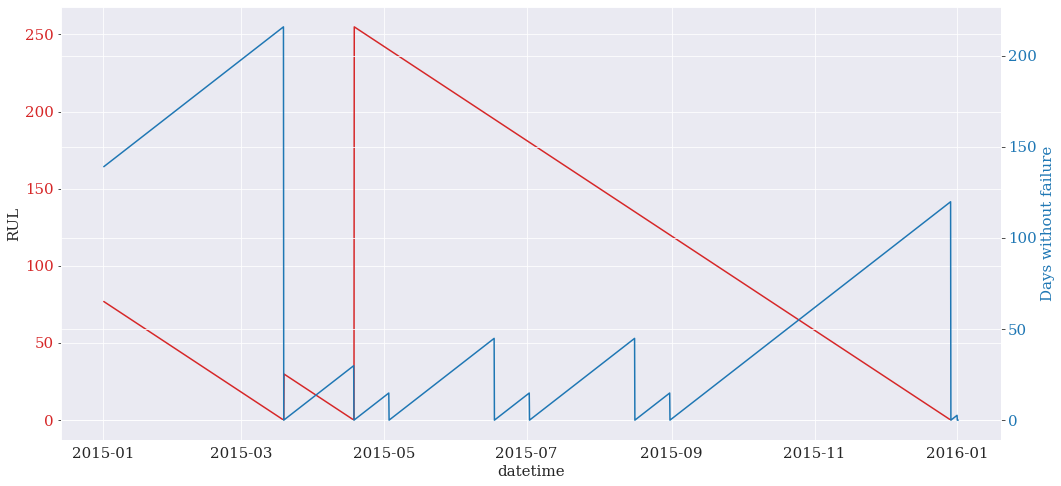

In [116]:
# Compare RUL with Time since last maintenance

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('datetime')
ax1.set_ylabel('RUL')
ax1.plot(fail_merged_rul.loc[fail_merged_rul['compressorID']==2]['datetime'], fail_merged_rul.loc[fail_merged_rul['compressorID']==2]['rul_comp2'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Days without failure', color=color)  # we already handled the x-label with ax1
ax2.plot(maint_feat.loc[maint_feat['compressorID']==2]['datetime'], maint_feat.loc[maint_feat['compressorID']==2]["comp2_maint"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.set_figheight(7)
fig.set_figwidth(15)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

**Errors visualization**

In [118]:
maint_feat.head()

datetime  compressorID  comp1_maint  comp2_maint  \
0      2015-01-01 09:00:00             1       19.125      214.125   
1      2015-01-01 12:00:00             1       19.250      214.250   
2      2015-01-01 15:00:00             1       19.375      214.375   
3      2015-01-01 18:00:00             1       19.500      214.500   
4      2015-01-01 21:00:00             1       19.625      214.625   
...                    ...           ...          ...          ...   
292095 2015-12-31 21:00:00           100       82.625        7.625   
292096 2016-01-01 00:00:00           100        0.000        0.000   
292097 2016-01-01 03:00:00           100        0.000        0.000   
292098 2016-01-01 06:00:00           100        0.000        0.000   
292099 2016-01-01 09:00:00           100        0.000        0.000   

        comp3_maint  comp4_maint  
0           154.125      169.125  
1           154.250      169.250  
2           154.375      169.375  
3           154.500      169.500  
4           154.625      169.625  
...             ...          ...  
292095       82.625       52.625  
292096        0.000        0.000  
292097        0.000        0.000  
292098        0.000        0.000  
292099        0.000        0.000  

[292100 rows x 6 columns]

### Merge with features

In [119]:
fail_merged.head()

datetime  compressorID  comp1_fail  comp2_fail  comp3_fail  \
0 2015-01-01 09:00:00             1         0.0         0.0         0.0   
1 2015-01-01 12:00:00             1         0.0         0.0         0.0   
2 2015-01-01 15:00:00             1         0.0         0.0         0.0   
3 2015-01-01 18:00:00             1         0.0         0.0         0.0   
4 2015-01-01 21:00:00             1         0.0         0.0         0.0   

   comp4_fail  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

In [120]:
fail_merged_rul.head()

datetime  compressorID  rul_comp1  rul_comp2  rul_comp3  \
0 2015-01-01 09:00:00             1     63.875    108.875        NaN   
1 2015-01-01 12:00:00             1     63.750    108.750        NaN   
2 2015-01-01 15:00:00             1     63.625    108.625        NaN   
3 2015-01-01 18:00:00             1     63.500    108.500        NaN   
4 2015-01-01 21:00:00             1     63.375    108.375        NaN   

   rul_comp4  
0      3.875  
1      3.750  
2      3.625  
3      3.500  
4      3.375

In [121]:
compressors_all_data = pd.concat([
    compressors_feat,
    fail_merged.iloc[:, 2:6],
    fail_merged_rul.iloc[:, 2:6]], axis=1)

In [122]:
compressors_all_data.head()

compressorID            datetime  cycle  current_mean_3h  rpm_mean_3h  \
0             1 2015-01-01 09:00:00      1       170.028993   449.533798   
1             1 2015-01-01 12:00:00      2       164.192565   403.949857   
2             1 2015-01-01 15:00:00      3       168.134445   435.781707   
3             1 2015-01-01 18:00:00      4       165.514453   430.472823   
4             1 2015-01-01 21:00:00      5       168.809347   437.111120   

   pressure_mean_3h  vibration_mean_3h  current_std_3h  rpm_std_3h  \
0         94.592122          40.893502        6.721032   67.849599   
1        105.687417          34.255891        7.596570   50.120452   
2        107.793709          41.239405       10.124584   55.084734   
3        101.703289          40.373739        4.673269   42.047278   
4         90.911060          41.738542       14.752132   47.048609   

   pressure_std_3h  ...    s-8760    c-8760  comp1_fail  comp2_fail  \
0        18.934956  ...  0.000000  1.000000         0.0         0.0   
1         8.555032  ...  0.002152  0.999998         0.0         0.0   
2         5.909721  ...  0.004304  0.999991         0.0         0.0   
3         4.554047  ...  0.006455  0.999979         0.0         0.0   
4         4.244158  ...  0.008607  0.999963         0.0         0.0   

   comp3_fail  comp4_fail  rul_comp1  rul_comp2  rul_comp3  rul_comp4  
0         0.0         0.0     63.875    108.875        NaN      3.875  
1         0.0         0.0     63.750    108.750        NaN      3.750  
2         0.0         0.0     63.625    108.625        NaN      3.625  
3         0.0         0.0     63.500    108.500        NaN      3.500  
4         0.0         0.0     63.375    108.375        NaN      3.375  

[5 rows x 67 columns]

In [123]:
failures['failure_comp'].value_counts()

comp2    259
comp1    192
comp4    179
comp3    131
Name: failure_comp, dtype: int64

In [124]:
times_repeated = (time_advanced_failure_detection/time_window_resample_hours)

In [125]:
times_repeated

16.0

In [126]:
compressors_all_data['comp1_fail'].value_counts()[1]/times_repeated

192.0

In [127]:
compressors_all_data['comp2_fail'].value_counts()[1]/times_repeated

259.0

In [128]:
compressors_all_data['comp3_fail'].value_counts()[1]/times_repeated

131.0

In [129]:
compressors_all_data['comp4_fail'].value_counts()[1]/times_repeated

179.0

# EDA compressor features data

### NaN analysis

In [131]:
compressors_all_data.head()

compressorID            datetime  cycle  current_mean_3h  rpm_mean_3h  \
0             1 2015-01-01 09:00:00      1       170.028993   449.533798   
1             1 2015-01-01 12:00:00      2       164.192565   403.949857   
2             1 2015-01-01 15:00:00      3       168.134445   435.781707   
3             1 2015-01-01 18:00:00      4       165.514453   430.472823   
4             1 2015-01-01 21:00:00      5       168.809347   437.111120   

   pressure_mean_3h  vibration_mean_3h  current_std_3h  rpm_std_3h  \
0         94.592122          40.893502        6.721032   67.849599   
1        105.687417          34.255891        7.596570   50.120452   
2        107.793709          41.239405       10.124584   55.084734   
3        101.703289          40.373739        4.673269   42.047278   
4         90.911060          41.738542       14.752132   47.048609   

   pressure_std_3h  ...    s-8760    c-8760  comp1_fail  comp2_fail  \
0        18.934956  ...  0.000000  1.000000         0.0         0.0   
1         8.555032  ...  0.002152  0.999998         0.0         0.0   
2         5.909721  ...  0.004304  0.999991         0.0         0.0   
3         4.554047  ...  0.006455  0.999979         0.0         0.0   
4         4.244158  ...  0.008607  0.999963         0.0         0.0   

   comp3_fail  comp4_fail  rul_comp1  rul_comp2  rul_comp3  rul_comp4  
0         0.0         0.0     63.875    108.875        NaN      3.875  
1         0.0         0.0     63.750    108.750        NaN      3.750  
2         0.0         0.0     63.625    108.625        NaN      3.625  
3         0.0         0.0     63.500    108.500        NaN      3.500  
4         0.0         0.0     63.375    108.375        NaN      3.375  

[5 rows x 67 columns]

In [132]:
compressors_all_data.isna().sum().to_frame().T

compressorID  datetime  cycle  current_mean_3h  rpm_mean_3h  \
0             0         0      0                0            0   

   pressure_mean_3h  vibration_mean_3h  current_std_3h  rpm_std_3h  \
0                 0                  0             100         100   

   pressure_std_3h  ...  s-8760  c-8760  comp1_fail  comp2_fail  comp3_fail  \
0              100  ...       0       0           0           0           0   

   comp4_fail  rul_comp1  rul_comp2  rul_comp3  rul_comp4  
0           0     137253      93509     212908     175548  

[1 rows x 67 columns]

### Visualizations

In this section we will visualize the different variables with respect to our target variable (failure in the different components).

From the featuring engineering, we now call failure_comp or in case of dummies 1.0, to the data which is potentially failing in the time frame specified previously. Hence, there will be a higher number of "failures" that the one shown in the previous section.

In [133]:
# Add compressor info to the whole dataset
compressors_all_data_model_fail = pd.concat([
    compressors_all_data,
    comp_info.iloc[:, 2]], axis=1)
compressors_all_data_model_fail.head()

compressorID            datetime  cycle  current_mean_3h  rpm_mean_3h  \
0             1 2015-01-01 09:00:00      1       170.028993   449.533798   
1             1 2015-01-01 12:00:00      2       164.192565   403.949857   
2             1 2015-01-01 15:00:00      3       168.134445   435.781707   
3             1 2015-01-01 18:00:00      4       165.514453   430.472823   
4             1 2015-01-01 21:00:00      5       168.809347   437.111120   

   pressure_mean_3h  vibration_mean_3h  current_std_3h  rpm_std_3h  \
0         94.592122          40.893502        6.721032   67.849599   
1        105.687417          34.255891        7.596570   50.120452   
2        107.793709          41.239405       10.124584   55.084734   
3        101.703289          40.373739        4.673269   42.047278   
4         90.911060          41.738542       14.752132   47.048609   

   pressure_std_3h  ...    c-8760  comp1_fail  comp2_fail  comp3_fail  \
0        18.934956  ...  1.000000         0.0         0.0         0.0   
1         8.555032  ...  0.999998         0.0         0.0         0.0   
2         5.909721  ...  0.999991         0.0         0.0         0.0   
3         4.554047  ...  0.999979         0.0         0.0         0.0   
4         4.244158  ...  0.999963         0.0         0.0         0.0   

   comp4_fail  rul_comp1  rul_comp2  rul_comp3  rul_comp4   model  
0         0.0     63.875    108.875        NaN      3.875  model3  
1         0.0     63.750    108.750        NaN      3.750  model3  
2         0.0     63.625    108.625        NaN      3.625  model3  
3         0.0     63.500    108.500        NaN      3.500  model3  
4         0.0     63.375    108.375        NaN      3.375  model3  

[5 rows x 68 columns]

In [134]:
# Add failure label, not only dummy, to understand the failures
compressors_all_data_model_fail = compressors_all_data_model_fail.merge(
    fail_comp_merged,
    on=["datetime", "compressorID"],
    how="outer").sort_values(by=["compressorID", "datetime"]
)
compressors_all_data_model_fail.head(15)

compressorID            datetime  cycle  current_mean_3h  rpm_mean_3h  \
0              1 2015-01-01 09:00:00      1       170.028993   449.533798   
1              1 2015-01-01 12:00:00      2       164.192565   403.949857   
2              1 2015-01-01 15:00:00      3       168.134445   435.781707   
3              1 2015-01-01 18:00:00      4       165.514453   430.472823   
4              1 2015-01-01 21:00:00      5       168.809347   437.111120   
5              1 2015-01-02 00:00:00      6       168.779396   486.242664   
6              1 2015-01-02 03:00:00      7       172.277489   477.738628   
7              1 2015-01-02 06:00:00      8       180.133784   440.608320   
8              1 2015-01-02 09:00:00      9       176.364293   439.349655   
9              1 2015-01-02 12:00:00     10       160.384568   424.385316   
10             1 2015-01-02 15:00:00     11       170.472461   442.933997   
11             1 2015-01-02 18:00:00     12       163.263806   468.937558   
12             1 2015-01-02 21:00:00     13       163.278466   446.493166   
13             1 2015-01-03 00:00:00     14       172.191198   434.214692   
14             1 2015-01-03 03:00:00     15       175.210027   504.845430   

    pressure_mean_3h  vibration_mean_3h  current_std_3h  rpm_std_3h  \
0          94.592122          40.893502        6.721032   67.849599   
1         105.687417          34.255891        7.596570   50.120452   
2         107.793709          41.239405       10.124584   55.084734   
3         101.703289          40.373739        4.673269   42.047278   
4          90.911060          41.738542       14.752132   47.048609   
5          90.446472          41.796657       15.901952   36.129552   
6          89.104865          41.232001        6.884615   46.850076   
7          94.137969          41.551544       21.322735   48.770512   
8         101.553209          36.105580       18.952210   51.329636   
9          99.598722          36.094637       13.047080   13.702496   
10        102.380586          40.483002       16.642354   56.290447   
11        102.726648          40.921802       17.424688   38.680380   
12        104.387585          38.068116       21.580492   41.380958   
13         93.747282          39.716482       16.369836   14.636041   
14        108.512153          37.763933        5.991921   16.062702   

    pressure_std_3h  ...  comp1_fail  comp2_fail  comp3_fail  comp4_fail  \
0         18.934956  ...         0.0         0.0         0.0         0.0   
1          8.555032  ...         0.0         0.0         0.0         0.0   
2          5.909721  ...         0.0         0.0         0.0         0.0   
3          4.554047  ...         0.0         0.0         0.0         0.0   
4          4.244158  ...         0.0         0.0         0.0         0.0   
5          4.310741  ...         0.0         0.0         0.0         0.0   
6          9.205122  ...         0.0         0.0         0.0         0.0   
7          2.135684  ...         0.0         0.0         0.0         0.0   
8         13.789279  ...         0.0         0.0         0.0         0.0   
9          9.988609  ...         0.0         0.0         0.0         0.0   
10         3.305739  ...         0.0         0.0         0.0         0.0   
11         9.105775  ...         0.0         0.0         0.0         0.0   
12        20.725597  ...         0.0         0.0         0.0         0.0   
13        18.817326  ...         0.0         0.0         0.0         0.0   
14         6.382608  ...         0.0         0.0         0.0         0.0   

    rul_comp1  rul_comp2  rul_comp3  rul_comp4   model  failure_comp  
0      63.875    108.875        NaN      3.875  model3          none  
1      63.750    108.750        NaN      3.750  model3          none  
2      63.625    108.625        NaN      3.625  model3          none  
3      63.500    108.500        NaN      3.500  model3          none  
4      63.375    108.375        NaN      3.375  model3        

In [135]:
# Count the different models data
compressors_all_data_model_fail.model.value_counts()

model3    102244
model4     93483
model2     49665
model1     46750
Name: model, dtype: int64

In [136]:
# Count the different component failures
compressors_all_data_model_fail.failure_comp.value_counts()

none     280611
comp2      4009
comp1      3072
comp4      2504
comp3      1946
Name: failure_comp, dtype: int64

#### Failures by model

In [137]:
#Delete the entries with no failure
compressors_all_data_model_failed = compressors_all_data_model_fail.loc[compressors_all_data_model_fail.failure_comp!= 'none']

Text(0.5, 1.0, 'Failures by model')

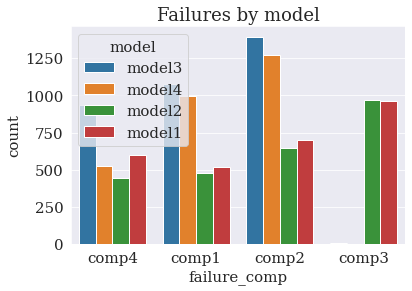

In [138]:
# Visualize the failures by model
sns.countplot(x="failure_comp", hue="model", data=compressors_all_data_model_failed).set_title('Failures by model')

#### Failures by age

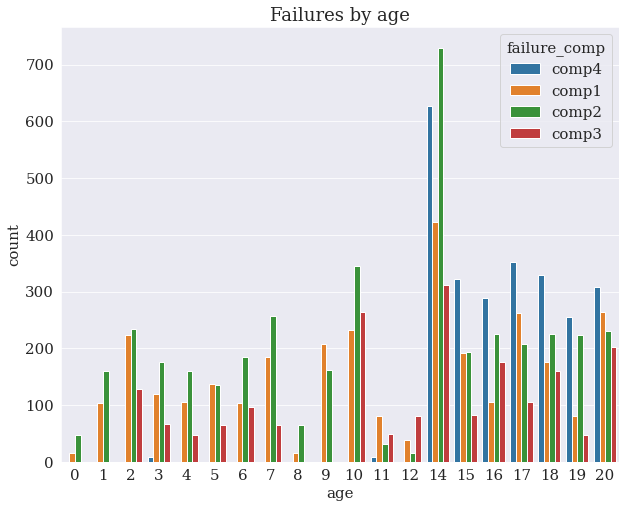

In [139]:
# Visualize the failures by model
f, ax = plt.subplots(figsize=(10, 8))
sns.countplot(x="age", hue="failure_comp", data=compressors_all_data_model_failed , ax=ax).set_title('Failures by age')
plt.show()

### Correlation Analysis


#### Create columns vectors

In [140]:
cols_sensors_lagged = [col for col in compressors_all_data.columns if ((str(time_lagged_sensors)+'h' in col) and (('mean' in col)|('max' in col)|('min' in col)))]
cols_sensors_window_resample = [col for col in compressors_all_data.columns if (str(time_window_resample_hours)+'h' in col) and ('mean' in col)]
cols_sensors_lagged_mean = [col for col in compressors_all_data.columns if ((str(time_lagged_sensors)+'h' in col) and ('mean' in col))]
cols_sensors_std = [col for col in compressors_all_data.columns if ('std' in col)]

cols_sensors_important = cols_sensors_window_resample + cols_sensors_lagged 
cols_sensors_all = cols_sensors_window_resample + cols_sensors_lagged + cols_sensors_std

In [141]:
cols_failures_dum = [col for col in compressors_all_data.columns if 'fail' in col]

In [142]:
cols_errors = [col for col in compressors_all_data.columns if (('error' in col) & ('count' not in col))]
cols_errors_count = [col for col in compressors_all_data.columns if (('error' in col) & ('count' in col))]
cols_maint = [col for col in compressors_all_data.columns if "maint" in col]

In [143]:
cols_compressor_status = cols_errors + cols_errors_count + cols_maint + cols_failures_dum

In [144]:
cols_model_dum = [col for col in compressors_all_data.columns if 'model' in col]
cols_comp_info = [col for col in compressors_all_data.columns if 'age' in col]

In [145]:
sensors_compressor_status = cols_sensors_lagged_mean + cols_compressor_status  + cols_model_dum + cols_comp_info
sensors_compressor_status

['current_mean_lag_24h',
 'rpm_mean_lag_24h',
 'pressure_mean_lag_24h',
 'vibration_mean_lag_24h',
 'error1',
 'error2',
 'error3',
 'error4',
 'error5',
 'error1count',
 'error2count',
 'error3count',
 'error4count',
 'error5count',
 'comp1_maint',
 'comp2_maint',
 'comp3_maint',
 'comp4_maint',
 'comp1_fail',
 'comp2_fail',
 'comp3_fail',
 'comp4_fail',
 'model2',
 'model3',
 'model4',
 'age']

In [146]:
target = cols_failures_dum[0]
target

'comp1_fail'

In [147]:
predictors = ['compressorID'] + cols_sensors_all + cols_errors + cols_errors_count + cols_maint  + cols_model_dum+ cols_comp_info
predictors

['compressorID',
 'current_mean_3h',
 'rpm_mean_3h',
 'pressure_mean_3h',
 'vibration_mean_3h',
 'current_mean_lag_24h',
 'rpm_mean_lag_24h',
 'pressure_mean_lag_24h',
 'vibration_mean_lag_24h',
 'current_max_lag_24h',
 'rpm_max_lag_24h',
 'pressure_max_lag_24h',
 'vibration_max_lag_24h',
 'current_min_lag_24h',
 'rpm_min_lag_24h',
 'pressure_min_lag_24h',
 'vibration_min_lag_24h',
 'current_std_3h',
 'rpm_std_3h',
 'pressure_std_3h',
 'vibration_std_3h',
 'current_std_lag_24h',
 'rpm_std_lag_24h',
 'pressure_std_lag_24h',
 'vibration_std_lag_24h',
 'error1',
 'error2',
 'error3',
 'error4',
 'error5',
 'error1count',
 'error2count',
 'error3count',
 'error4count',
 'error5count',
 'comp1_maint',
 'comp2_maint',
 'comp3_maint',
 'comp4_maint',
 'model2',
 'model3',
 'model4',
 'age']

In [148]:
categorical = cols_errors + cols_model_dum+ cols_comp_info
categorical

['error1',
 'error2',
 'error3',
 'error4',
 'error5',
 'model2',
 'model3',
 'model4',
 'age']

In [149]:
cols_seasonal= []
for period in [24,24*7,24*365]:
  cols_seasonal.append(f"s-{period}")
  cols_seasonal.append(f"c-{period}")

#### Sensors

First we want to understand if there is any correlation between the telemetry variables:
- rpm
- current
- pressure
- vibration


In [151]:
#cols_sensors_h = [col for col in test_predicted_final.columns if str(time_window_resample_hours)+'h' in col]
cols_sensors_h_lag = [col for col in compressors_all_data.columns if str(time_lagged_sensors)+'h' in col]
cols_sensors_h_lag = [col for col in cols_sensors_h_lag if 'mean' in col]

#cols_sensors = cols_sensors_24h + cols_sensors_h
cols_sensors =  cols_sensors_h_lag

We see there is no correlation between sensors


In [152]:
compressors_all_data_sensors= compressors_all_data[compressors_all_data.columns.intersection(cols_sensors)]

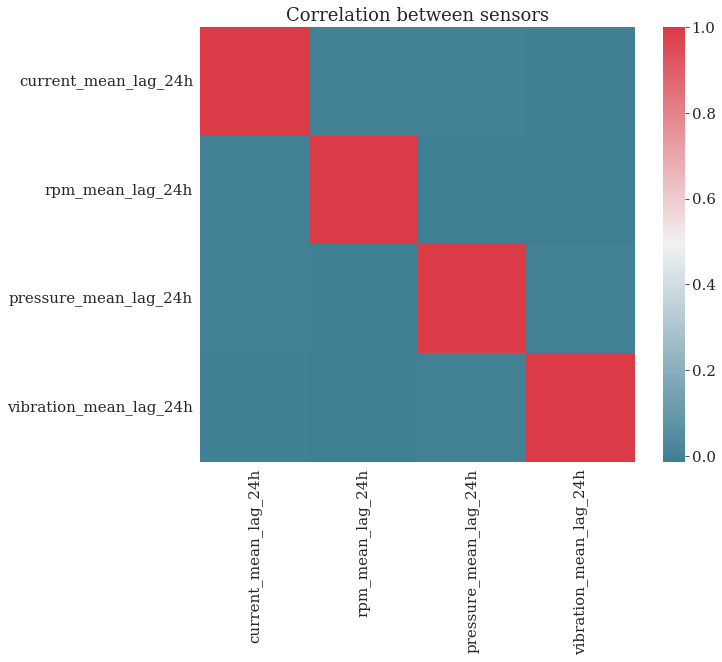

In [153]:
f, ax = plt.subplots(figsize=(10, 8))
corr = compressors_all_data_sensors.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title("Correlation between sensors")
plt.show()

#### Compressor status


Correlation between maint-error-failure

A HeatMap will be displayed to show the correlation between failures, maintenance and errors. 

There is high correlation between error2 and error3, thus, they might be affecting to the same failure type. Moreover, there is also correlation between maintenance and failures.

In [154]:
compressors_all_data_status = compressors_all_data[cols_compressor_status]

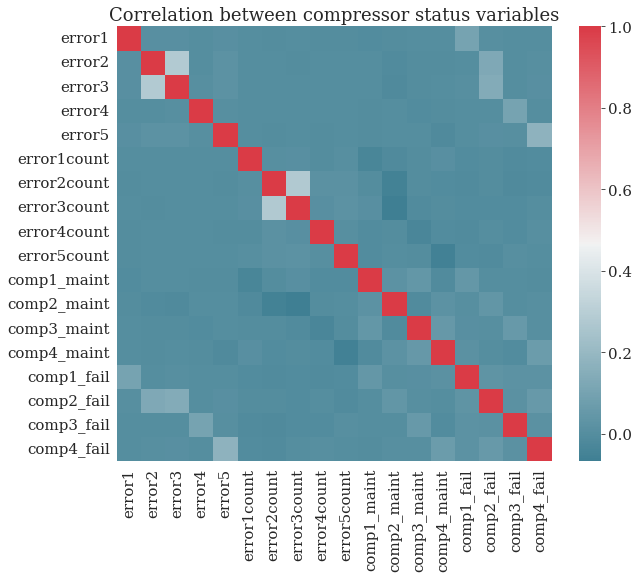

In [155]:
f, ax = plt.subplots(figsize=(10, 8))
corr = compressors_all_data_status.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title("Correlation between compressor status variables")
plt.show()

#### Failure vs (Sensors & compressor status)

In [156]:
compressors_all_data_cor = compressors_all_data[sensors_compressor_status]

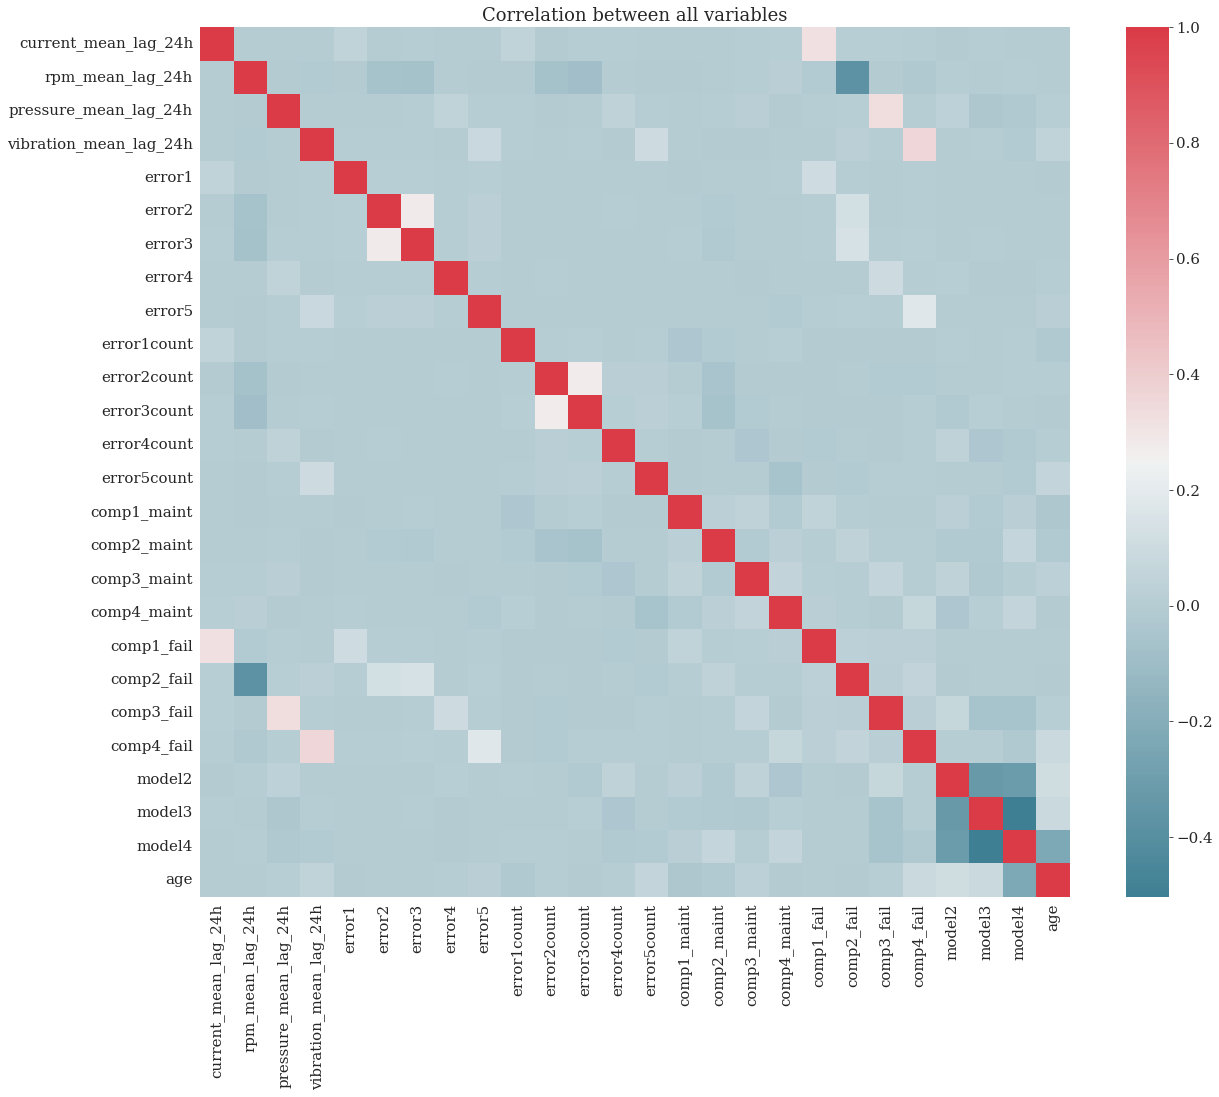

In [157]:
f, ax = plt.subplots(figsize=(20, 16))
corr = compressors_all_data_cor.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title("Correlation between all variables")
plt.show()

**Insights from the correlations**

- Error 1 -> high currents -> Fail component 1
- Error 2 -> low rpm -> Fail component 2
- Error 3 -> low rpm -> Fail component 2
- Error 4 -> high pressures ->Fail component 3
- Error 5 -> high vibrations -> Fail component 4




### Plots when failure

#### Sensors when compressor fails

Use historic data and see when a machine fails



In [158]:
compressors_all_data_fails = compressors_all_data.merge(failures, on=["datetime", "compressorID"], how="left")
compressors_all_data_fails["failure_comp"] = compressors_all_data_fails["failure_comp"].astype(object).fillna("none")
compressors_all_data_fails["failure_comp"] = compressors_all_data_fails["failure_comp"].astype("category")
compressors_all_data_fails.head()

compressorID            datetime  cycle  current_mean_3h  rpm_mean_3h  \
0             1 2015-01-01 09:00:00      1       170.028993   449.533798   
1             1 2015-01-01 12:00:00      2       164.192565   403.949857   
2             1 2015-01-01 15:00:00      3       168.134445   435.781707   
3             1 2015-01-01 18:00:00      4       165.514453   430.472823   
4             1 2015-01-01 21:00:00      5       168.809347   437.111120   

   pressure_mean_3h  vibration_mean_3h  current_std_3h  rpm_std_3h  \
0         94.592122          40.893502        6.721032   67.849599   
1        105.687417          34.255891        7.596570   50.120452   
2        107.793709          41.239405       10.124584   55.084734   
3        101.703289          40.373739        4.673269   42.047278   
4         90.911060          41.738542       14.752132   47.048609   

   pressure_std_3h  ...    c-8760  comp1_fail  comp2_fail  comp3_fail  \
0        18.934956  ...  1.000000         0.0         0.0         0.0   
1         8.555032  ...  0.999998         0.0         0.0         0.0   
2         5.909721  ...  0.999991         0.0         0.0         0.0   
3         4.554047  ...  0.999979         0.0         0.0         0.0   
4         4.244158  ...  0.999963         0.0         0.0         0.0   

   comp4_fail  rul_comp1  rul_comp2  rul_comp3  rul_comp4  failure_comp  
0         0.0     63.875    108.875        NaN      3.875          none  
1         0.0     63.750    108.750        NaN      3.750          none  
2         0.0     63.625    108.625        NaN      3.625          none  
3         0.0     63.500    108.500        NaN      3.500          none  
4         0.0     63.375    108.375        NaN      3.375          none  

[5 rows x 68 columns]

In [159]:
compressors_all_data_fails_comp = compressors_all_data_fails.loc[compressors_all_data_fails['compressorID'] == 13]

In [160]:
compressors_all_data_fails_comp['datetime_ms'] = pd.to_datetime(compressors_all_data_fails_comp['datetime'], unit='ms')

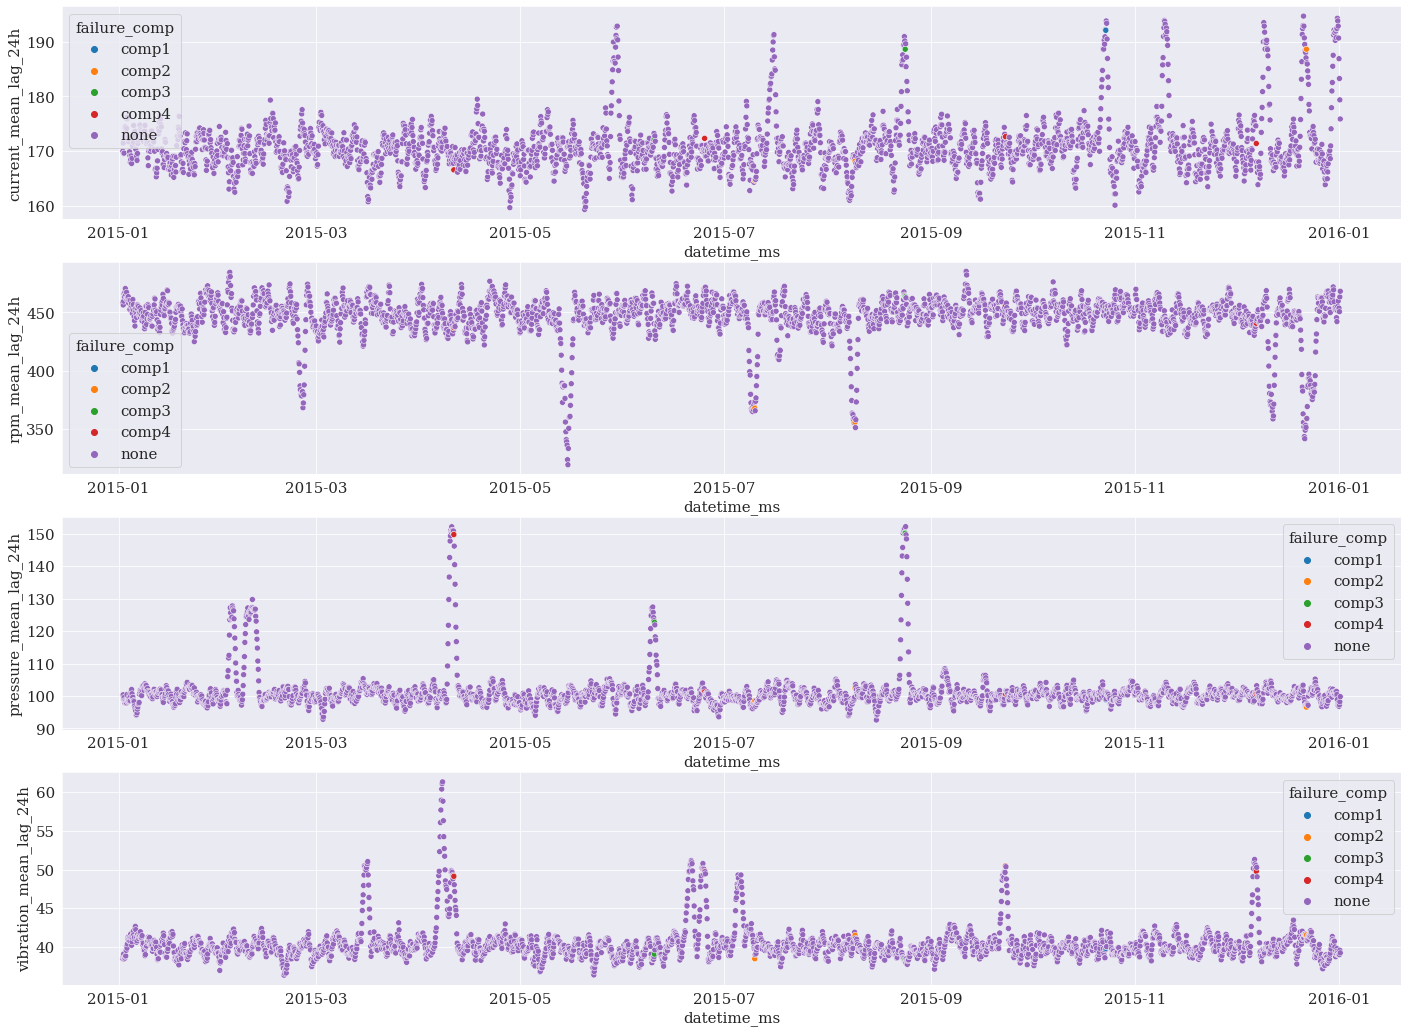

In [161]:
figure, axes = plt.subplots((len(cols_sensors)),1,figsize=(24,18))
i= 0
for col in cols_sensors:
  sns.scatterplot(ax = axes[i],
                  data= compressors_all_data_fails_comp, # Compressor id 3
                  x='datetime_ms', 
                  y=col, 
                  hue= 'failure_comp')
  i = i +1 

In [162]:
threshold_dates = [
    pd.to_datetime("2015-01-01 01:00:00"), pd.to_datetime("2015-05-01 01:00:00")
]

In [163]:
x= sensors.loc[(sensors['compressorID'] == 3) & (sensors['datetime'] > threshold_dates[0]) & (sensors['datetime'] < threshold_dates[1])]['datetime']
y= sensors.loc[(sensors['compressorID'] == 3) & (sensors['datetime'] > threshold_dates[0]) & (sensors['datetime'] < threshold_dates[1])]

In [164]:
y

datetime  compressorID     current         rpm    pressure  \
17522 2015-01-01 06:00:00             3  185.482043  461.211137   87.453199   
17523 2015-01-01 07:00:00             3  179.818516  519.166185  109.318603   
17524 2015-01-01 08:00:00             3  165.616803  467.107482  101.285580   
17525 2015-01-01 09:00:00             3  165.007013  391.994872   98.825669   
17526 2015-01-01 10:00:00             3  138.898164  488.764118  102.800017   
...                   ...           ...         ...         ...         ...   
20392 2015-04-30 20:00:00             3  189.011639  471.456642  107.285836   
20393 2015-04-30 21:00:00             3  153.675075  437.888852   91.004046   
20394 2015-04-30 22:00:00             3  185.686303  424.526668  117.695615   
20395 2015-04-30 23:00:00             3  175.126479  461.463492   96.062581   
20396 2015-05-01 00:00:00             3  148.456614  468.800920  101.807648   

       vibration  
17522  28.216864  
17523  37.290722  
17524  34.530035  
17525  27.495507  
17526  44.698218  
...          ...  
20392  40.786325  
20393  36.634807  
20394  39.237237  
20395  38.706461  
20396  42.408419  

[2875 rows x 6 columns]

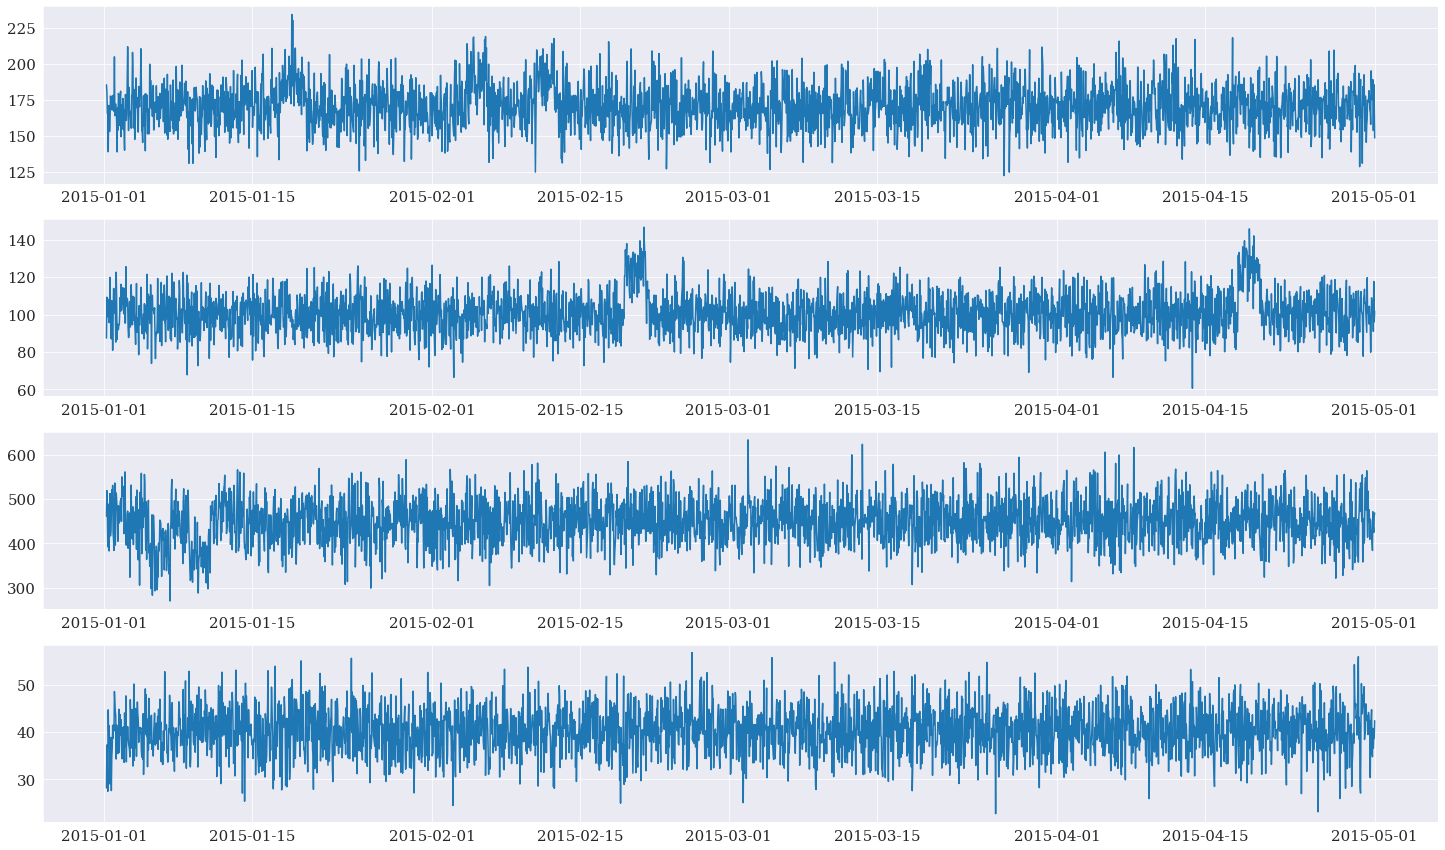

In [165]:
figure, axes = plt.subplots(4,1,figsize=(25,15))
axes[0].plot(x,y['current'])
axes[1].plot(x,y['pressure'])
axes[2].plot(x,y['rpm'])
axes[3].plot(x,y['vibration'])

**Insights**

The peaks in the pressure are provoking the compressor component number 4 to fail

#### Errors and maintenance vs failure

In [166]:
compressors_all_data_fails['failure_comp'].value_counts()

none     291381
comp2       259
comp1       192
comp4       179
comp3       131
Name: failure_comp, dtype: int64

Filter failure = none and show only relevant data

In [167]:
compressors_all_data_fails = compressors_all_data_fails.loc[compressors_all_data_fails['failure_comp'] != 'none']

Graph classifying by component failure

In [168]:
compressors_all_data_fails['datetime_ms'] = pd.to_datetime(compressors_all_data_fails['datetime'], unit='ms')

In [169]:
cols_errors_maint = cols_errors+ cols_maint

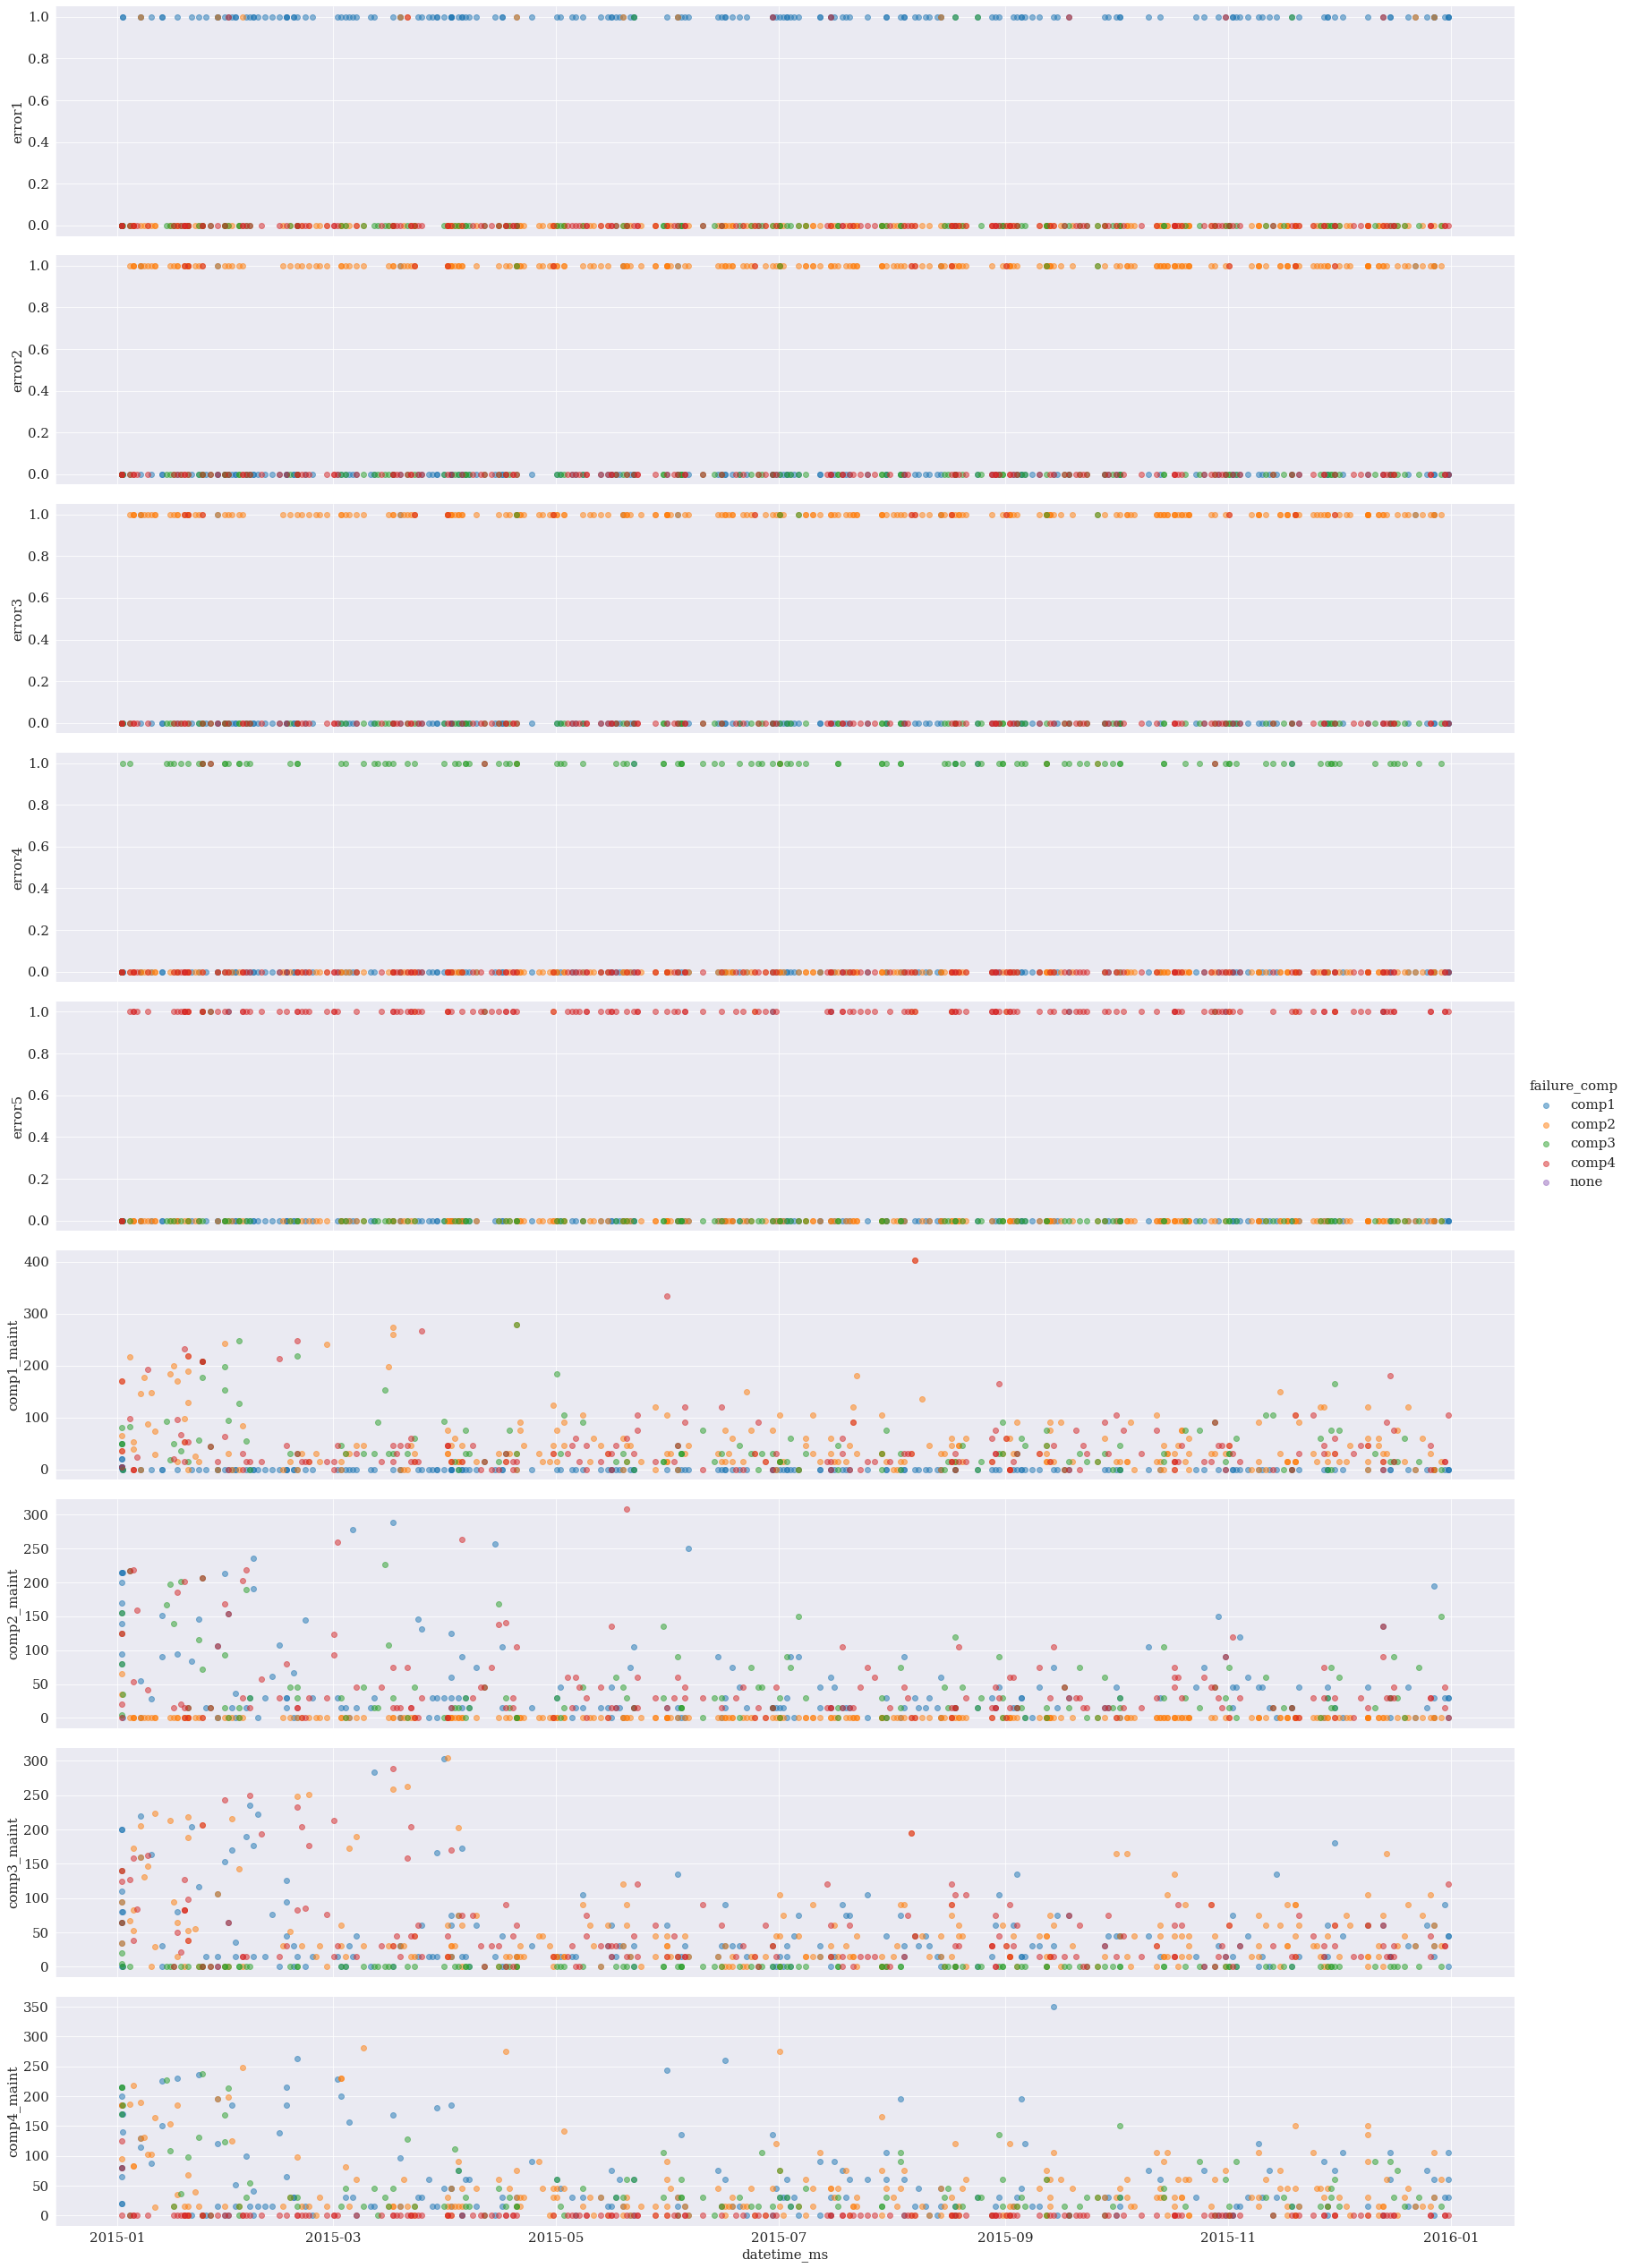

In [170]:
# use seaborn to visualize featuresto target 
explore = sns.PairGrid(data=compressors_all_data_fails,
                 x_vars='datetime_ms',
                 y_vars=cols_errors_maint,
                 hue="failure_comp", size=4, aspect=6)
explore = explore.map(plt.scatter, alpha=0.5)
explore = explore.add_legend()

We can easy grab the following insights:

- error1 -> failure comp 1
- error2 -> failure comp 2
- error3 -> failure comp 2
- error4 -> failure comp 3
- error5 -> failure comp 4

#### Sensors vs failure

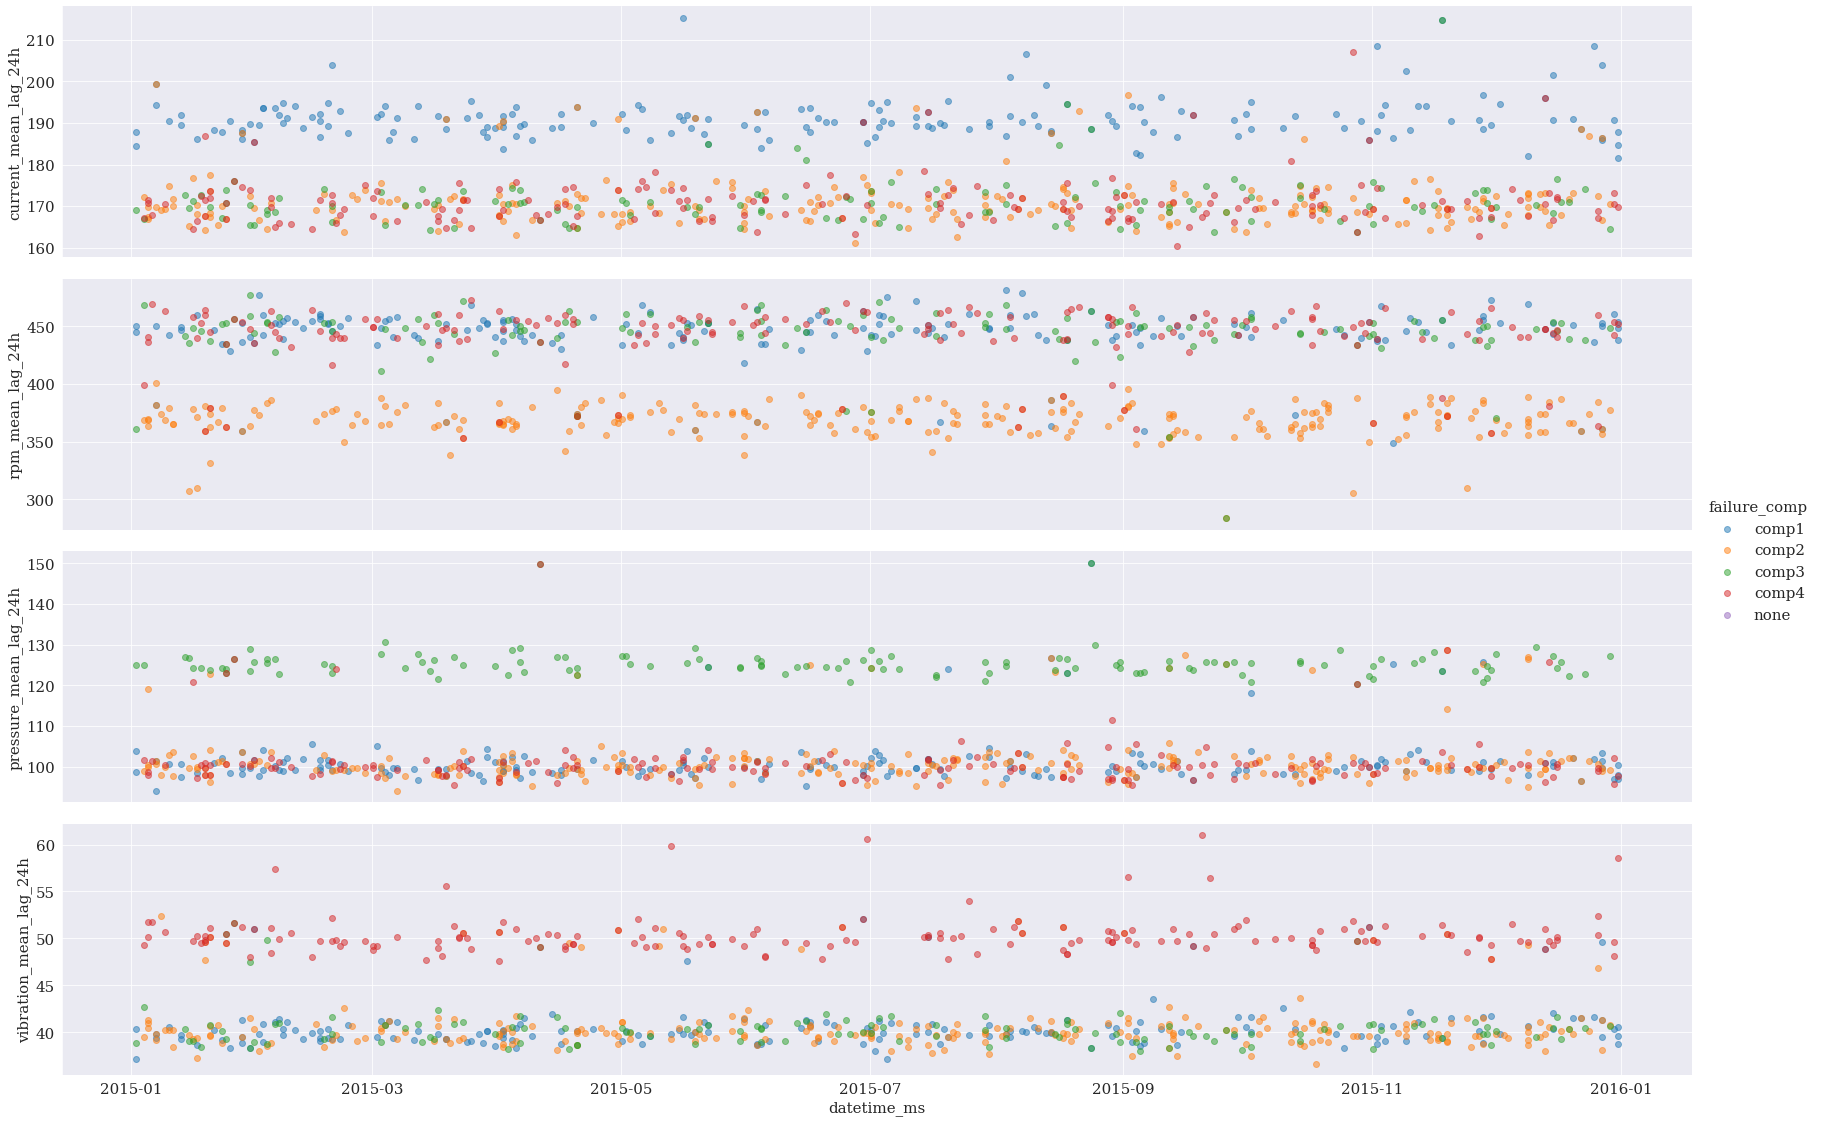

In [171]:
# use seaborn
explore = sns.PairGrid(data=compressors_all_data_fails,
                 x_vars='datetime_ms',
                 y_vars=cols_sensors,
                 hue="failure_comp", size=4, aspect=6)
explore = explore.map(plt.scatter, alpha=0.5)
explore = explore.add_legend()

We can easy grab the following insights:

- high currents -> failure comp 1
- low rpms -> failure comp 2
- high pressures -> failure comp 3
- high vibrations -> failure comp 4

#### Sensor data by type of failure

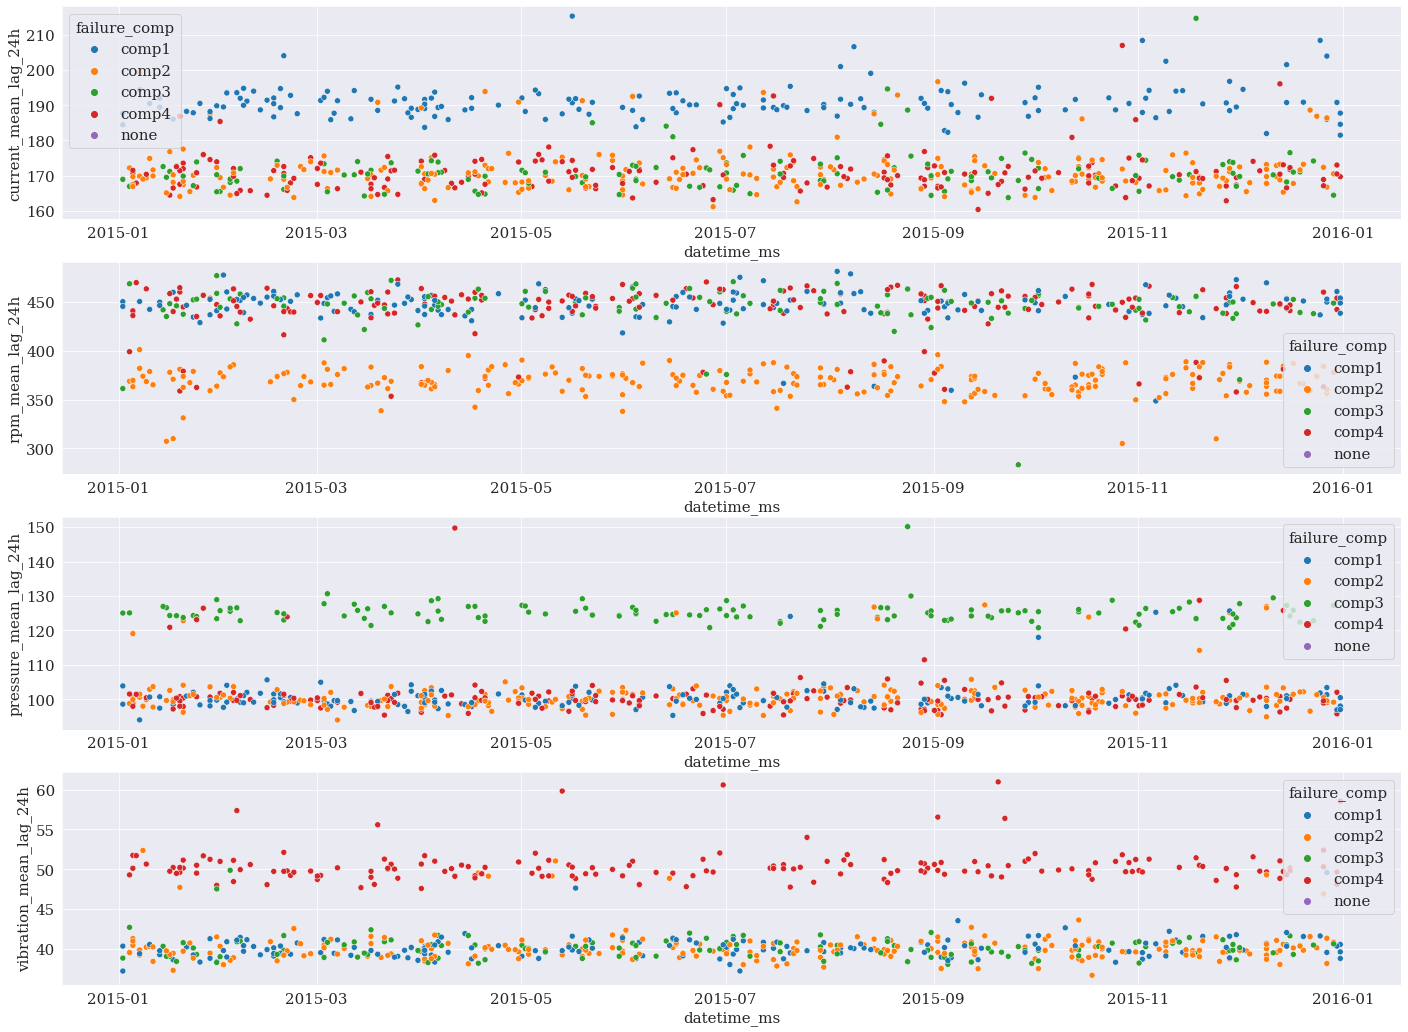

In [172]:
figure, axes = plt.subplots((len(cols_sensors)),1,figsize=(24,18))
i= 0
for col in cols_sensors:
  sns.scatterplot(ax = axes[i],
                  data= compressors_all_data_fails, 
                  x='datetime_ms', 
                  y=col, 
                  hue= 'failure_comp')
  i = i +1 

Only for a machine


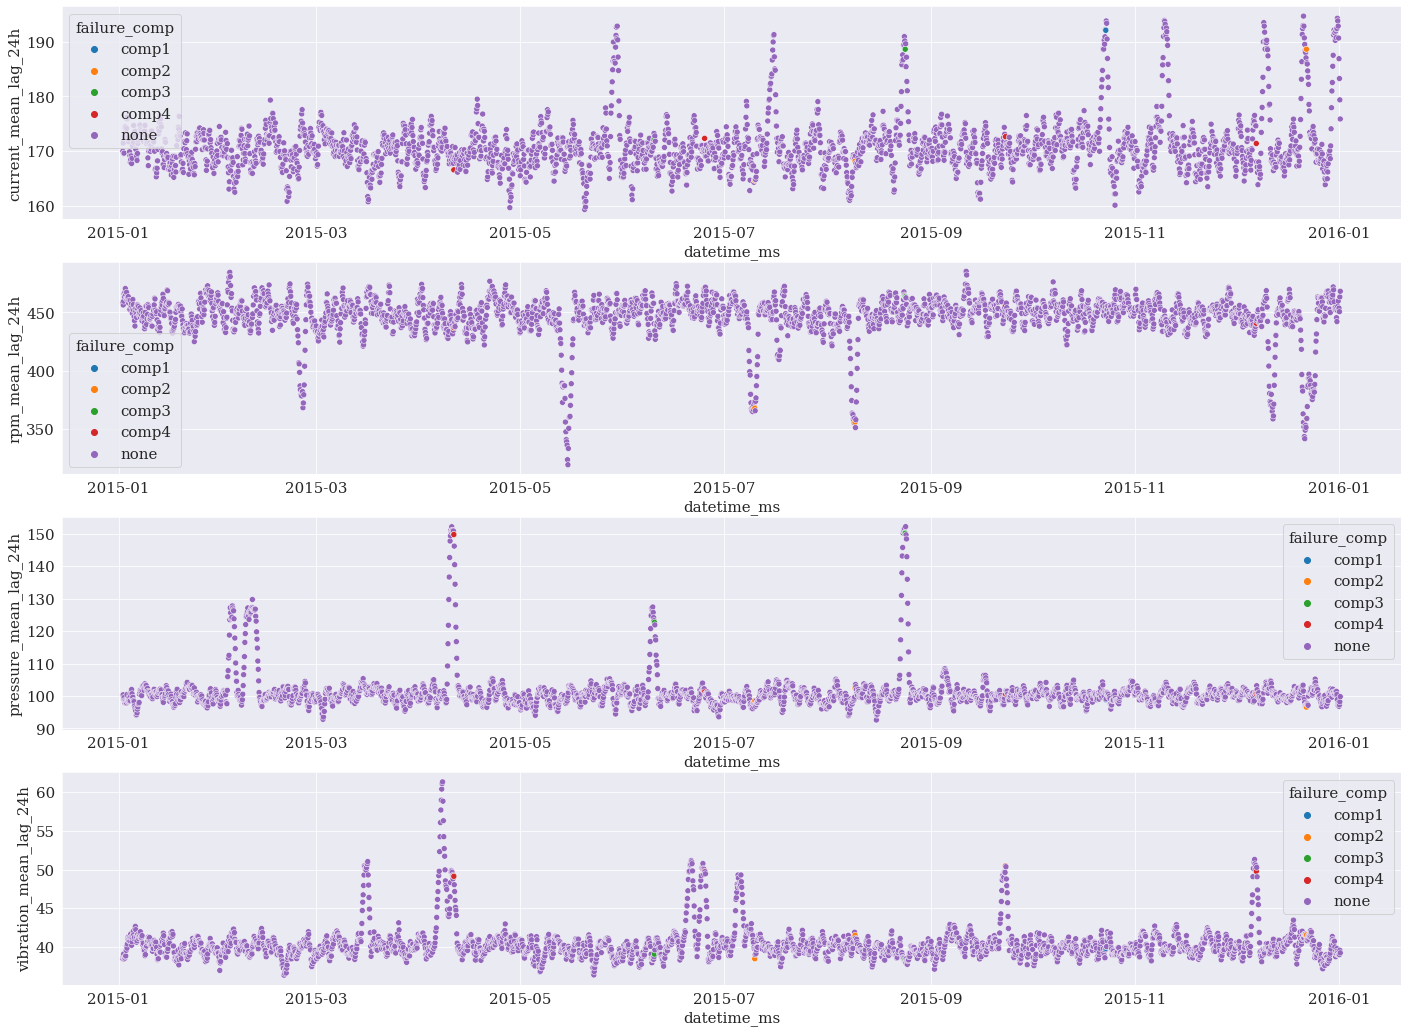

In [173]:
figure, axes = plt.subplots((len(cols_sensors)),1,figsize=(24,18))
i= 0
for col in cols_sensors:
  sns.scatterplot(ax = axes[i],
                  data= compressors_all_data_fails_comp, 
                  x='datetime_ms', 
                  y=col, 
                  hue= 'failure_comp')
  i = i +1 

#### Failures by model

**WARNING** is not failure what is being displayed, but failure state

In [174]:
compressors_all_data_model = pd.concat([
    compressors_all_data,
    comp_info.iloc[:, 2]], axis=1)

In [175]:
compressors_all_data_model_reduced = compressors_all_data_model.loc[(compressors_all_data_model["datetime"] > threshold_dates[0]) 
                                                                  & (compressors_all_data_model["datetime"] < threshold_dates[1])]

In [176]:
compressors_all_data_model_reduced['datetime_ms'] = pd.to_datetime(compressors_all_data_model_reduced['datetime'], unit='ms')

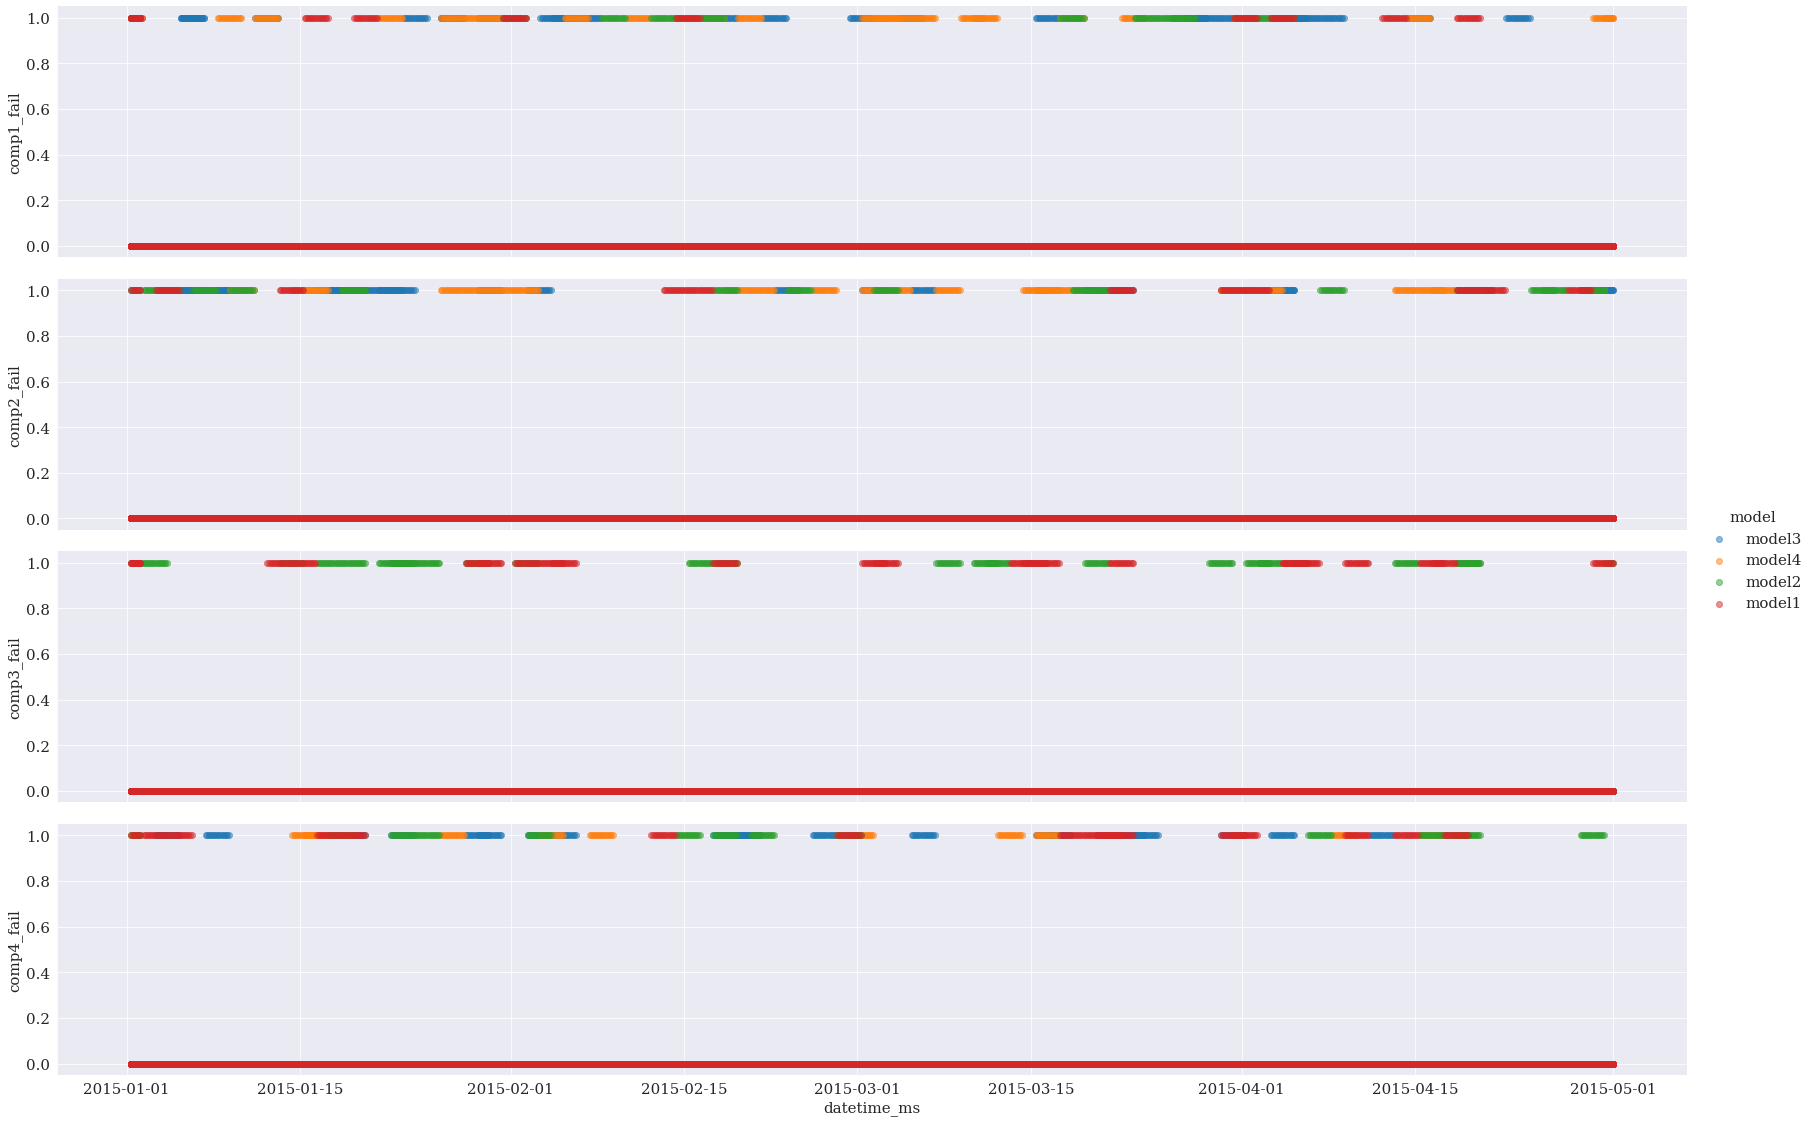

In [177]:
# use seaborn
explore = sns.PairGrid(data=compressors_all_data_model_reduced,
                 x_vars='datetime_ms',
                 y_vars=cols_failures_dum,
                 hue="model", size=4, aspect=6)
explore = explore.map(plt.scatter, alpha=0.5)
explore = explore.add_legend()

#### Components replaced that didn't fail
**Relation Failures to Maintenance**



Next we will keep only failures as categorical value and we will use the dummified dataframes for errors and maintenance

In [178]:
threshold_dates = [
    pd.to_datetime("2015-05-01 01:00:00"), pd.to_datetime("2015-06-01 01:00:00")
]

Create an inverval of time and check the count of maintenance and errors to be linked with failures

In [179]:
compressors_all_data_fails_reduced = compressors_all_data_fails.loc[(compressors_all_data_fails["datetime"] > threshold_dates[0]) & 
                                                                      (compressors_all_data_fails["datetime"] < threshold_dates[1])]

In [180]:
compressors_all_data_fails_reduced['failure_comp'].value_counts()

comp2    21
comp4    17
comp1    16
comp3    10
none      0
Name: failure_comp, dtype: int64

In [181]:
cols_errors_maint = cols_errors + cols_maint

**Comparison between maintenance applied and failures**

Several insights can be graspped from the exploration:

1. Sometimes, maintenance is applied to a component which has not failed. 
2. For some failures, several components are replaced. 



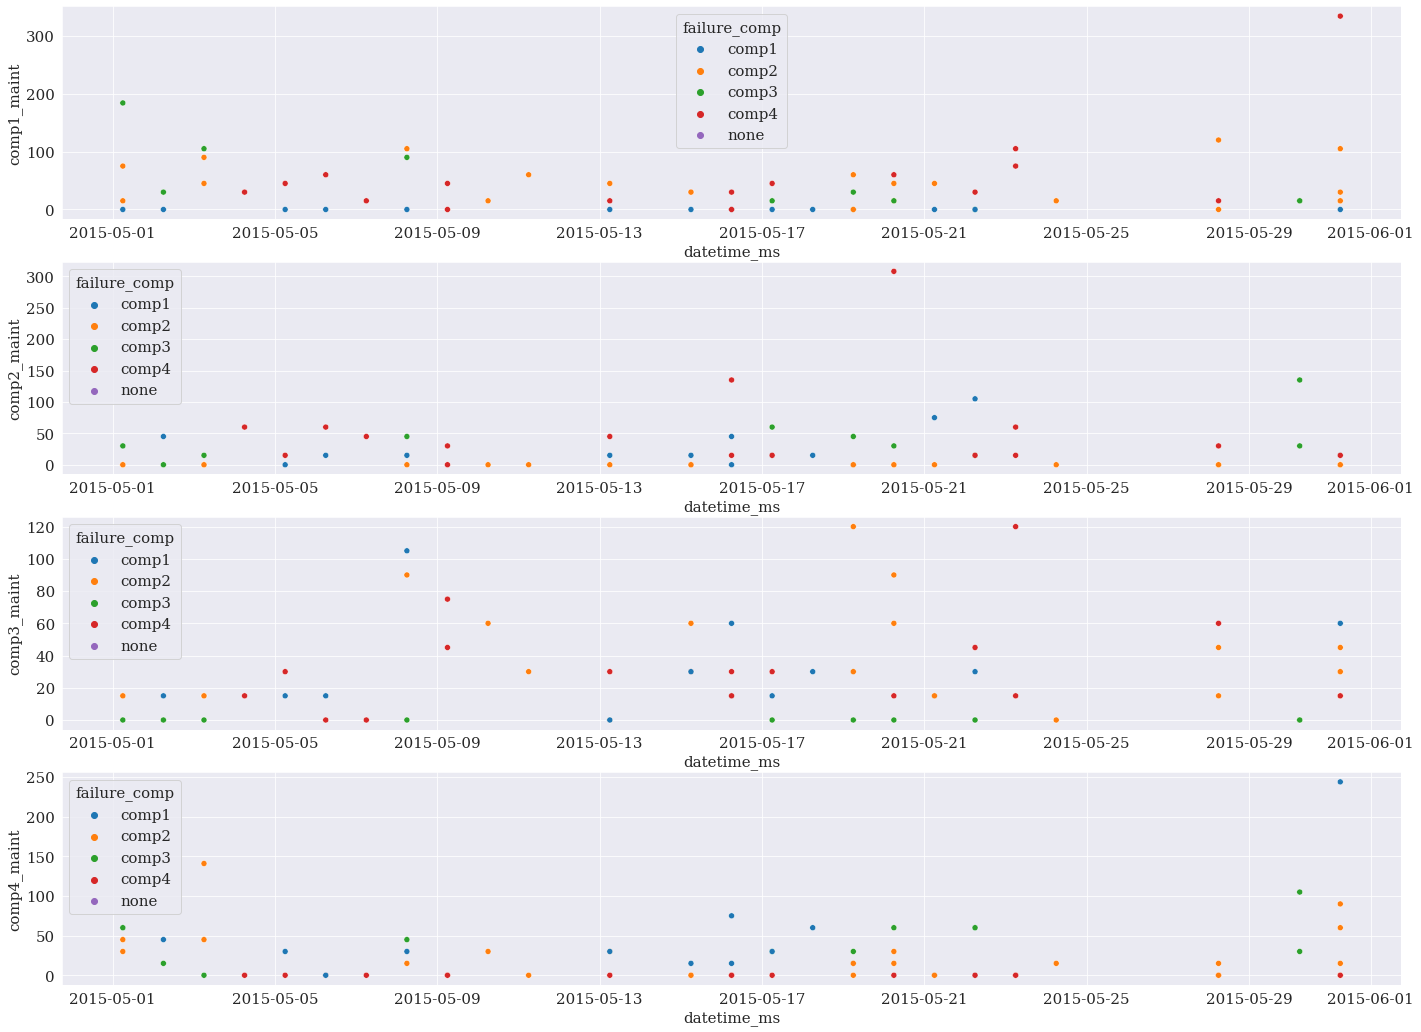

In [182]:
figure, axes = plt.subplots((len(cols_maint)),1,figsize=(24,18))
i= 0
for col in cols_maint:
  sns.scatterplot(ax = axes[i],
                  data= compressors_all_data_fails_reduced, 
                  x='datetime_ms', 
                  y=col, 
                  hue= 'failure_comp')
  i = i +1 

**Relations from the graph above:**

Every time a component fails is maintained .




### Component lifetime

In [183]:
rul_comp_cols = ['rul_comp1' , 'rul_comp2', 'rul_comp3', 'rul_comp4']

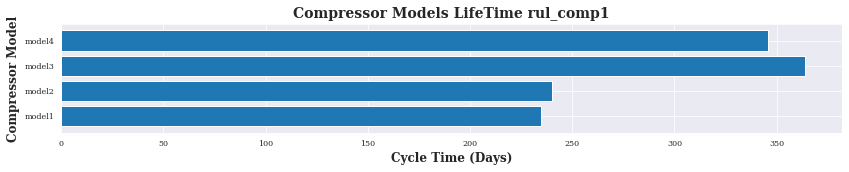

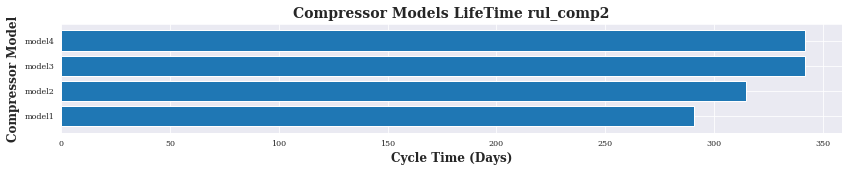

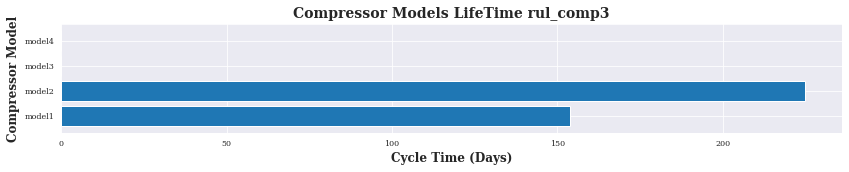

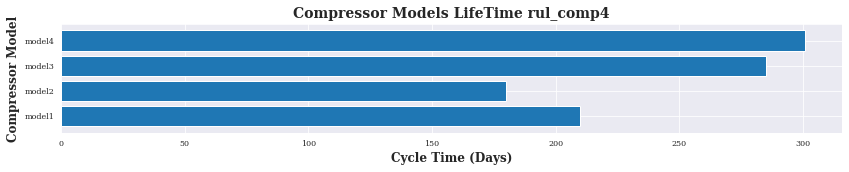

In [184]:
for comp in rul_comp_cols:
  plt.figure(figsize=(14,2))
  ax=compressors_all_data_model.groupby('model')[comp].max().plot(kind='barh',width=0.8, stacked=True,align='center',rot=0)
  plt.title('Compressor Models LifeTime ' + comp,fontweight='bold',size=14)
  plt.xlabel('Cycle Time (Days)',fontweight='bold',size=12)
  plt.xticks(size=8)
  plt.ylabel('Compressor Model',fontweight='bold',size=12)
  plt.yticks(size=8)
  plt.grid(True)
  #plt.tight_layout(True)
  plt.show()

## Features importance

How are the maintenance and errors affecting the failures?




In [185]:
compressors_all_data_na = compressors_all_data.dropna(axis=0)

In [186]:
y=compressors_all_data_na[cols_failures_dum]

Select all the feature columns to see the importance of each one in the prediction

In [187]:
cols_sensors = [col for col in compressors_all_data.columns if ((str(time_lagged_sensors)+'h' in col)|(str(time_window_resample_hours)+'h' in col))]


In [188]:
predictors = ['compressorID'] + ['cycle'] + cols_sensors + cols_errors + cols_errors_count + cols_maint  + cols_model_dum+ cols_comp_info +cols_seasonal

In [189]:
X=compressors_all_data_na[predictors]


In [190]:
X.head()

compressorID  cycle  current_mean_3h  rpm_mean_3h  pressure_mean_3h  \
35059            13      8       179.178056   492.030275         91.155905   
35060            13      9       169.073051   451.528135         95.460869   
35061            13     10       170.608473   476.470942        100.674812   
35062            13     11       174.670838   475.862555         97.439909   
35063            13     12       182.207294   454.472370         95.440034   

       vibration_mean_3h  current_std_3h  rpm_std_3h  pressure_std_3h  \
35059          38.162571       27.497743   11.183028        17.366019   
35060          42.752140       19.283389   75.098589         4.837571   
35061          36.086376       21.764942   60.931854        12.521208   
35062          36.744674       23.224006   23.873635        13.829958   
35063          41.682170       14.765826   42.989149        15.565441   

       vibration_std_3h  ...  model2  model3  model4  age          s-24  \
35059          3.862876  ...       0       0       0   15 -7.071068e-01   
35060          3.597729  ...       0       0       0   15 -2.449294e-16   
35061          4.204943  ...       0       0       0   15  7.071068e-01   
35062          1.797458  ...       0       0       0   15  1.000000e+00   
35063          3.872835  ...       0       0       0   15  7.071068e-01   

               c-24     s-168     c-168    s-8760    c-8760  
35059  7.071068e-01  0.707107  0.707107  0.015062  0.999887  
35060  1.000000e+00  0.781831  0.623490  0.017213  0.999852  
35061  7.071068e-01  0.846724  0.532032  0.019365  0.999812  
35062  3.061617e-16  0.900969  0.433884  0.021516  0.999769  
35063 -7.071068e-01  0.943883  0.330279  0.023667  0.999720  

[5 rows x 58 columns]

In [191]:
y.head()

comp1_fail  comp2_fail  comp3_fail  comp4_fail
35059         0.0         0.0         0.0         0.0
35060         0.0         0.0         0.0         0.0
35061         0.0         0.0         0.0         0.0
35062         0.0         0.0         0.0         0.0
35063         0.0         0.0         0.0         0.0

In [195]:
# I like to use a simple random forest to determine some of the most important/meaningful features. Can be used as feature selection
# create an exhuastive random forest (200 trees up to 15 levels deep)
rf = ensemble.RandomForestRegressor()
single_rf = ensemble.RandomForestRegressor(n_estimators = 25, max_depth = 5)

In [196]:
comp_rul_col = list(y.columns)

In [197]:
y_pred = pd.DataFrame()

complete---comp1_fail


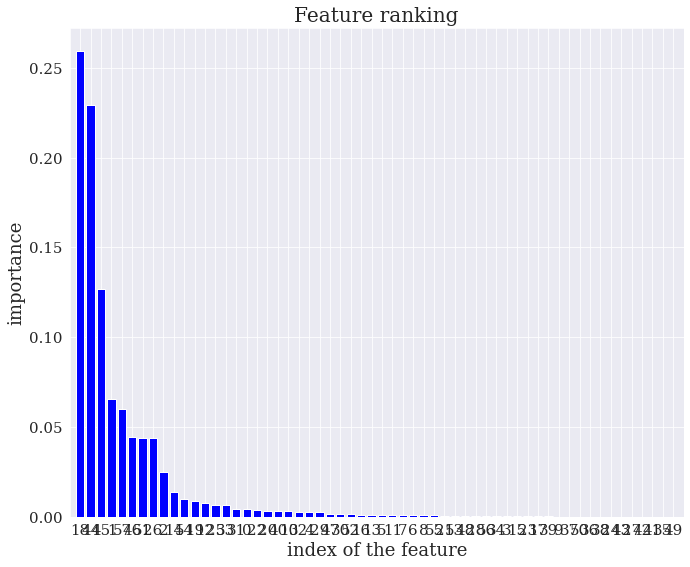

current_mean_lag_24h    0.259365
comp1_maint             0.229501
comp2_maint             0.126689
cycle                   0.065766
c-8760                  0.060167
comp3_maint             0.044368
age                     0.044055
current_max_lag_24h     0.043719
current_mean_3h         0.024796
current_min_3h          0.013823
dtype: float64
complete---comp2_fail


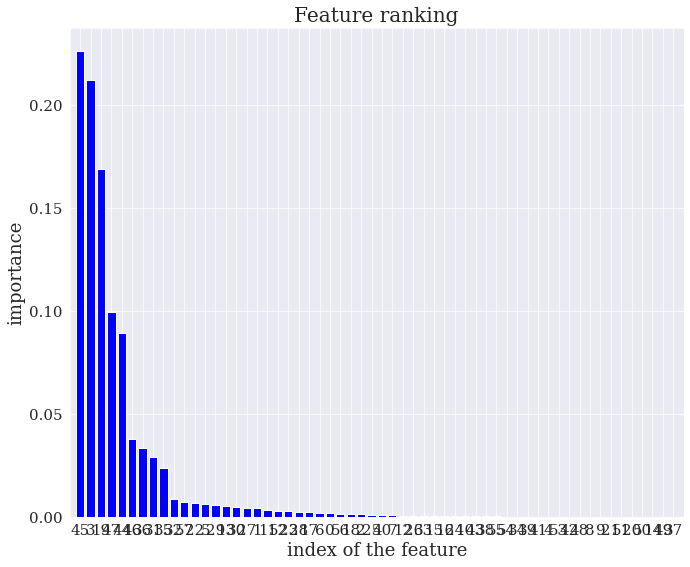

comp2_maint             0.226283
rpm_mean_3h             0.212152
rpm_mean_lag_24h        0.168764
comp4_maint             0.099302
comp1_maint             0.089327
comp3_maint             0.037811
error3                  0.033423
rpm_min_lag_24h         0.029241
error2                  0.023585
pressure_min_lag_24h    0.008692
dtype: float64
complete---comp3_fail


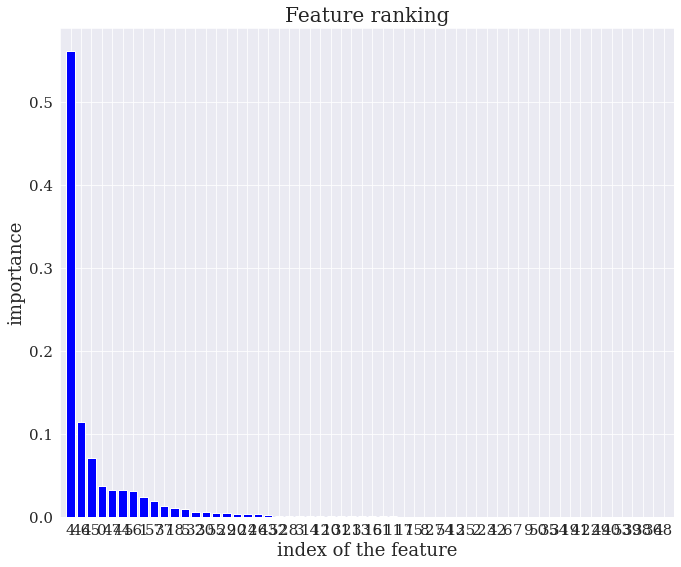

pressure_mean_3h    0.561885
comp3_maint         0.114767
comp2_maint         0.070847
compressorID        0.037171
comp4_maint         0.031902
comp1_maint         0.031718
s-8760              0.030558
cycle               0.023336
c-8760              0.019325
error4              0.013601
dtype: float64
complete---comp4_fail


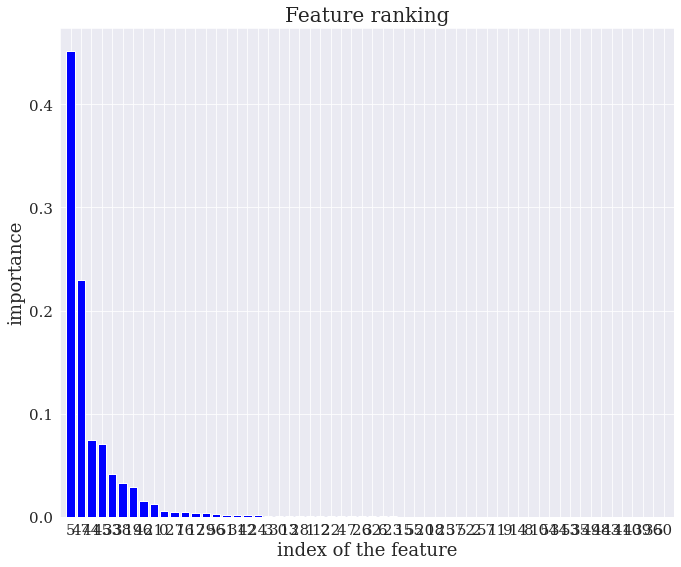

vibration_mean_3h         0.451894
comp4_maint               0.229845
comp1_maint               0.074119
comp2_maint               0.070168
vibration_min_lag_24h     0.041049
error5                    0.033166
rpm_mean_lag_24h          0.029006
comp3_maint               0.015000
vibration_mean_lag_24h    0.011937
compressorID              0.005344
dtype: float64


In [198]:
for comp in comp_rul_col:
  single_rf.fit(X, y[comp])
  y_pred[comp] = single_rf.predict(X)
  print("complete---" + comp)
  # graph feature importance
  importances = single_rf.feature_importances_
  indices = np.argsort(importances)[::-1]
  feature_names = X.columns    
  f, ax = plt.subplots(figsize=(11, 9))
  plt.title("Feature ranking", fontsize = 20)
  plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
  plt.xticks(range(X.shape[1]), indices) #feature_names, rotation='vertical')
  plt.xlim([-1, X.shape[1]])
  plt.ylabel("importance", fontsize = 18)
  plt.xlabel("index of the feature", fontsize = 18)
  plt.show()
  # list feature importance
  important_features = pd.Series(data=single_rf.feature_importances_,index=X.columns)
  important_features.sort_values(ascending=False,inplace=True)
  print(important_features.head(10))

# Export CSV

Select the best predictors

In [ ]:
cols_sensors_lagged = [col for col in compressors_all_data.columns if ((str(time_lagged_sensors)+'h' in col) and (('mean' in col)|('max' in col)|('min' in col)))]
cols_sensors_window_resample = [col for col in compressors_all_data.columns if (str(time_window_resample_hours)+'h' in col) and ('mean' in col)]

cols_sensors_important = cols_sensors_window_resample + cols_sensors_lagged 

In [ ]:
cols_sensors_important

In [ ]:
cols_errors = [col for col in compressors_all_data.columns if (('error' in col) & ('count' not in col))]
cols_errors_count = [col for col in compressors_all_data.columns if (('error' in col) & ('count' in col))]

In [ ]:
cols_maint = [col for col in compressors_all_data.columns if "maint" in col]

In [ ]:
cols_model_dum = [col for col in compressors_all_data.columns if 'model' in col]
cols_comp_info = [col for col in compressors_all_data.columns if 'age' in col]

In [ ]:
cols_seasonal= []
for period in [24,24*7,24*365]:
  cols_seasonal.append(f"s-{period}")
  cols_seasonal.append(f"c-{period}")

In [ ]:
best_predictors = ['compressorID'] + ['datetime'] + ['cycle'] + cols_sensors_important + cols_errors + cols_errors_count + cols_maint  + cols_model_dum+ cols_comp_info +cols_seasonal

In [ ]:
best_predictors

In [ ]:
cols_rul= [col for col in compressors_all_data.columns if ('rul' in col)]
cols_fail= [col for col in compressors_all_data.columns if ('fail' in col)]

In [ ]:
target = cols_fail + cols_rul

In [ ]:
target

In [ ]:
compressors_all_data[best_predictors + target].to_csv('compressors_all_data_best_features_2days.csv')

In [ ]:
compressors_all_data[best_predictors + target]